<a href="https://colab.research.google.com/github/oamerl/machine-learning-projects/blob/main/Deep-Learning/anti-cancer-activity-prediction/anti_cancer_activity_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

***Input file (sdf file) format description:***

* The provided file contains chemical info about different compounds
* the file is read as text file (strings) and we split it into a list of strings using \$$$$ as each graph data is separated by this separator
* each string in the obtained list will correspond to a graph data
* for each graph data string in the list we split it into lines
* we access the needed item (node or edge data) by using number of spaces that the line starts with.
* lines that contain nodes symbol start with 4 whitespaces
* lines that contain edges data start with 2 whitespaces
* for each graph string data there is a line that starts with 2 whitespace and is not an edge info line, this line should be handled when we read edges data
* above mentioned line contains number of nodes and edges in the graph
* for nodes info we only take the atom character which is at index 3
* for edges info we take index 0 and 1 only corresponding to src node and dest node and we skip index 2 which represents edge type (bond type)
* to identify the graph label we can observe that its line will always start with the characters '1.0' or '-1.0' without any leading spaces

***Input tensors to the neural network model, dims and their meaning:***

* the graph neural network takes 4 tensors
* the first tensor is "node_features" which is the embedded tensor which represents the nodes features vector in our case each node is represented by a single character or eqivalently a single number if tokenized and this token is embedded so dimensions of emedding tensor will be:
(total_number_of_nodes_per_batch, chosen_vector_representation_length) --> (batch_size \* max_nodes_per_graph "if we do padding", 20)  
* the second tensor is the "adjacency_lists" which the list of edges each edge is represented by 2 values (src,dest) so dimesions will be (number_of_edges_per_batch, 2)
* the third tensor is the node_to_graph which is responsible to give information about which nodes belong to which graphs so it is mainly nodes' graphs indicies vector so it will have the dimensions of (total_number_of_nodes_per_batch, 1) --> (batch_size \* max_nodes_per_graph, 1) where 1 means 1 value that will be the graph index number. Note that in code we don't write 1 we leave it empty.
* the last input tensor is the num_graphs which is the number of graphs in the batch this is a scalar value

* gnn_out is the node-level representation which is essentialy a tensor that contains the all nodes in the batch and their final state/vector/message representation so it will be of size
(total_number_of_nodes_per_batch, hidden_dim) --> (batch_size \* max_nodes_per_graph, hidden_dim)
where hidden_dim is the chosen vector length representation for each node message in our case we set it to 32

***The difference between segment_mean and tf.reduce_mean for each dim of pred:***

* segment_mean function calculates the mean across specified segments by using passed indcies so the function is typically given a tensor that we want to calculate the mean of its elements not all together but different groups so we want to group different elements together so another input is given which is the indcies that idicates which elements to be grouped together and calculate their mean so result is reduced to multidimensional.
In our case we calculate the mean of each graph nodes so depending on number of grpahs per batch and the vector length of each message the dimensionality of the obtained average will be set (number_of_graphs_per_batch, hidden_dim) --> (batch_size, hidden_dim) --> (32, 32)
* tf.reduce_mean on the otherhand is used to calculate mean for all passed elements across certain axis it doesn't group elements and so on the calculated mean is for all elements
* pred dimension is (number of graphs, number of hidden units) --> (number of graphs, 1)
where pred is the graph-level prediction and the prediction here is just 1 integer 0 or 1

***The motivation/theory/idea to use multiple gcn layers comparing to just one:***

* For the first GCN layer nodes will collect messages from their first-tier neighbours only
* All nodes will collect these messages and be updated
* if we put another GCN layer, now nodes will be collecting info about their first-tier as well as their 2nd-tier neigbours. 2nd-tier neighbours info will come from their 1st-tier neighbours as they have been updated during the previous layer and now each node will know more info about its surronding
* If we kept putting GCN layer after layer we are essentially increasing the "receptive field" of the nodes, if we can call it so as in case of images in CNN.
* Increasing this receptive field of nodes will have positive impact on graph tasks performance same as in RNN the longer the sequence the better.
* However we should dont just keep putting GCN layers without caution as we will be faced by the over smoothing issue in which all nodes will be having/representing the same info during which there will be no diffrentiation among the nodes
* The template used the default parameters and default value of number of GCN layers is 4 however we tried different values such as 3 at different trials.

# **2- Data Reading 📋**
Reading SDF format data files (structured-data format)

SDF is text file "string" and each entry in our case a graph is separated by \$$$$.

In [ ]:
import numpy as np
from tqdm.notebook import tqdm

def read_sdf(file):
    with open(file, 'r') as rf:
        content = rf.read()
        print(content)
    samples = content.split('$$$$') # split text file into a list using the separatot $$$$ (list of string values of graphs data)

    def parse_sample(s):
        """ given a graph SDF string data it returns a list of tuples containing each graph data as nodes symbols(features), adjacency list and graph-level label"""

        lines = s.splitlines() # splitting the graph string data into separate lines
        links = [] # graph edges (adjacency list)
        nodes = [] # graph nodes (symbols)
        label = 0 # label for each value(graph) in the list

        for l in lines:

            # graph-level labels
            if l.strip() == '1.0':
                label = 1
            if l.strip() == '-1.0':
                label = 0

            # graph nodes features
            if l.startswith('    '): # this is how we'll identify the rows that contain the nodes symbol
                feature = l.split()
                node = feature[3] # taking the symbol of the node
                nodes.append(node)

            # graph edges (adjacency list)
            elif l.startswith(' '): # this is how we'll identify the rows that contain the edges (however there is another statistics row with same "  " that we should handle)
                lnk = l.split()
                # edge: (from, to,) (1-based index)
                if int(lnk[0]) - 1 < len(nodes): # this condition is skip the statistics row that happens to be starting with "  " as the edges rows
                    # appending adjacency tuples converting it to zero-based indexing
                    links.append((
                        int(lnk[0])-1,
                        int(lnk[1])-1, # zero-based index
                        # int(lnk[2]) ignore edge weight
                    ))
        return nodes, np.array(links), label # returned as a tuple

    return [parse_sample(s) for s in tqdm(samples) if len(s[0]) > 0] # list comprehension of tuples that will contain each graph data




Reading training data graphs and dividing data into training and validation datasets

In [ ]:
from sklearn.model_selection import train_test_split

training_set = read_sdf('train.sdf')
y = np.array(training_set) # to stratify with graph labels when splitting data
training_set, validation_set = train_test_split(training_set, test_size=0.15, stratify=y[:,-1], random_state=0, shuffle =True)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



  0%|          | 0/25024 [00:00<?, ?it/s]

<ipython-input-2-e1a89a3b74c5>:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  y = np.array(training_set)


In [ ]:
print(training_set[1]) # printing a sample graph data (Note its a tuple)

(['S', 'S', 'S', 'N', 'N', 'N', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C'], array([[ 0, 10],
       [ 0, 17],
       [ 1, 12],
       [ 2, 16],
       [ 2, 21],
       [ 3,  7],
       [ 3, 12],
       [ 4,  8],
       [ 4, 12],
       [ 5, 11],
       [ 5, 13],
       [ 5, 19],
       [ 6,  7],
       [ 6,  8],
       [ 6, 11],
       [ 7,  9],
       [ 8, 10],
       [ 9, 13],
       [ 9, 14],
       [10, 15],
       [14, 16],
       [15, 18],
       [16, 20],
       [17, 18],
       [20, 22],
       [21, 22]]), 0)


Reading testing data graphs

In [ ]:
testing_set  = read_sdf('test_x.sdf')

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



  0%|          | 0/12326 [00:00<?, ?it/s]

Oversampling the 'minority' class in the training set

In [ ]:
from imblearn.over_sampling import RandomOverSampler
random_oversampler = RandomOverSampler(sampling_strategy = 'minority',random_state=0) # initializing the oversampler

Separate the graph data and labels to be able to perfrom oversampling

In [ ]:
training_set = np.array(training_set) # converting training set to numpy array to be able to index it
X_graph_data = training_set[:,0:-1] # graph data (nodes and edges)
y_graph_label = training_set[:,-1] # graph label

<ipython-input-6-6cdf3f2544e1>:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  training_set = np.array(training_set)


Checking the classes count to see the imbalancing between them

In [ ]:
np.unique(y_graph_label, return_counts=True)

(array([0, 1], dtype=object), array([20235,  1035]))

In [ ]:
# convert the data type of the graph label from int to np.int otherwise an error is raised when oversampling
y_graph_label = y_graph_label.astype(np.int)

<ipython-input-8-ee251449305a>:2: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_graph_label = y_graph_label.astype(np.int)


In [ ]:
training_set[0] # printing a sample graph data (Note its a numpy array)

array([list(['O', 'O', 'O', 'O', 'O', 'O', 'O', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C']),
       array([[ 0,  9],
              [ 0, 10],
              [ 1,  8],
              [ 2, 12],
              [ 2, 18],
              [ 3, 10],
              [ 4, 15],
              [ 4, 21],
              [ 5, 18],
              [ 6, 21],
              [ 7,  8],
              [ 7, 10],
              [ 7, 11],
              [ 8, 13],
              [ 8, 14],
              [ 9, 11],
              [ 9, 12],
              [12, 15],
              [13, 17],
              [14, 16],
              [16, 19],
              [17, 19],
              [18, 20],
              [20, 23],
              [20, 24],
              [21, 22],
              [22, 25],
              [22, 26],
              [23, 27],
              [24, 28],
              [25, 30],
              [26, 31],
              [27, 29],
              [28, 29],
    

In [ ]:
print(y_graph_label[0]) # checking the separated label of a sample graph
print(X_graph_data[0]) # checking the separated data of a sample graph

1
[list(['O', 'O', 'O', 'O', 'O', 'O', 'O', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C'])
 array([[ 0,  9],
        [ 0, 10],
        [ 1,  8],
        [ 2, 12],
        [ 2, 18],
        [ 3, 10],
        [ 4, 15],
        [ 4, 21],
        [ 5, 18],
        [ 6, 21],
        [ 7,  8],
        [ 7, 10],
        [ 7, 11],
        [ 8, 13],
        [ 8, 14],
        [ 9, 11],
        [ 9, 12],
        [12, 15],
        [13, 17],
        [14, 16],
        [16, 19],
        [17, 19],
        [18, 20],
        [20, 23],
        [20, 24],
        [21, 22],
        [22, 25],
        [22, 26],
        [23, 27],
        [24, 28],
        [25, 30],
        [26, 31],
        [27, 29],
        [28, 29],
        [30, 32],
        [31, 32]])]


Oversampling the minority

In [ ]:
X_graph_data_resampled, y_graph_label_resampled = random_oversampler.fit_resample(X_graph_data, y_graph_label)

Now we want to concatenate/append the graph labels with the graph data, to do so we need to reshape the graph labels to be a column vector, also appended arrays must have same number of dimensions, without reshaping but X_graph_data_resampled has 2 dimension(s) and y_graph_label_resampled has 1 dimension(s)

In [ ]:
y_graph_label_resampled

array([1, 0, 0, ..., 1, 1, 1])

In [ ]:
y_graph_label_resampled = y_graph_label_resampled.reshape(len(y_graph_label_resampled),-1)
y_graph_label_resampled

array([[1],
       [0],
       [0],
       ...,
       [1],
       [1],
       [1]])

Checking the classes count after oversampling

In [ ]:
np.unique(y_graph_label_resampled, return_counts=True)

(array([0, 1]), array([20235, 20235]))

In [ ]:
#concate the input with output to the training dataset
training_set = np.append(X_graph_data_resampled, y_graph_label_resampled, axis=1) # appending column-wise

# **3- Visualizing/Inspecting a Sample Graph 💡**

In [ ]:
!pip install --quiet networkx # for graph visualization
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib import cm
colors = cm.rainbow(np.linspace(0, 1, 50)) # 50 values from 0 to 1 uniformly spaced

In [ ]:
def visualize(sample):
    """ given a graph data such as nodes, and edges it plots the graph"""
    G = nx.Graph()
    nodes = sample[0]
    edges = sample[1]

    labeldict={}
    node_color=[]
    for i,n in enumerate(nodes):
        G.add_node(i)
        labeldict[i]=n
        node_color.append(colors[hash(n)%len(colors)])

    # a list of edges:
    for e in edges:
        G.add_edge(e[0], e[1])

    nx.draw_networkx(G, labels=labeldict, with_labels = True, node_color = node_color)
    plt.show()

    return G

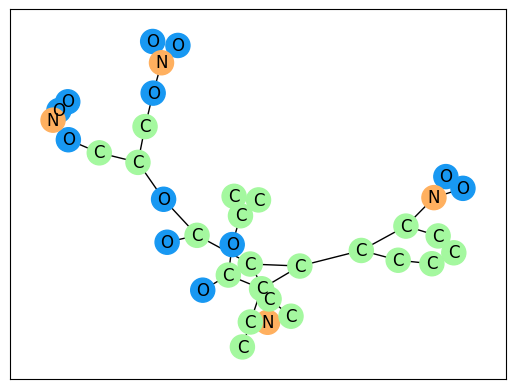

In [ ]:
plt.clf()
visualize(training_set[20])

# **4- Graphs Data Preprocessing 🧼**

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer

max_vocab = 500 # maximum number of unique nodes in all graphs (the number is an assumption)
max_len = 100 # maximum number of nodes per graph (the number is an assumption)
# note that above numbers can be obtained by code using the training data however we wont be sure that testing data will be bounded by them so assuming large numbers seems to be a safer option

# build vocabulary from training set
all_nodes = [s[0] for s in training_set] # s[0] is list of nodes
tokenizer = Tokenizer(num_words=max_vocab) # initializing the tokenizer
tokenizer.fit_on_texts(all_nodes) # each node symbol will be having numerical representation that we can apply on our nodes

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
import random
random.seed(0)

def prepare_single_batch(samples):
    """ given a batch of graphs say [graph1 graph2 graph3] returns batch level nodes, edges and graphs labels"""

    # batch nodes handling
    sample_nodes = [s[0] for s in samples] # list of lists containing nodes symbols of the batch [["N", "O", "C", ...], ["C", "S", "C", ...], ...]
    sample_nodes = tokenizer.texts_to_sequences(sample_nodes) # nodes numeric representation [[1, 2, 3, ...], [3, 4, 3, ...], ...]
    sample_nodes = pad_sequences(sample_nodes, padding='post') # nodes numeric representation with padding [[1, 2, 3, ..., 0], [3, 4, 3, ...0,0], ...] where 0 is the padding value
    max_nodes_len = np.shape(sample_nodes)[1] # maximum number of nodes per graph (will be the same for all graphs as we applied the padding)

    # batch edges handling
    edges = [s[1]+i*max_nodes_len for i,s in enumerate(samples)] # adjusting the nodes indicies of each graph (shifting them by i*max_nodes_len) as they will form a single adjacency list of the batch
    edges = [e for e in edges if len(e) > 0] # removes empty edges if exist

    # graphs indicies handling (which nodes belong to which graphs)
    node_to_graph = [[i]*max_nodes_len for i in range(len(samples))] # list of lists [[0, 0, 0, ..., 0], [1, 1, 1, ...1,1], ...]

    # adjusting the shapes
    all_nodes = np.reshape(sample_nodes, -1) # nodes features vector of the batch [1, 2, 3, ..., 0,3, 4, 3, ...0,0, ...]
    all_edges = np.concatenate(edges) # adjacency list of the batch
    node_to_graph = np.reshape(node_to_graph, -1) # vector of graphs indicies of the nodes [0,0,0, ...,0, 1,1,1, ....1,1, 2,2,...]

    return {
        'data': all_nodes,
        'edges': all_edges,
        'node2grah': node_to_graph,
    }, np.array([s[2] for s in samples]) # graph-level labels of the batch
    # a tuple of (dict, array of graphs labels) is returned


def gen_batch(dataset, batch_size=16, repeat=False, shuffle=True):
    """ given a set of graphs it divides them into batches and return the prepared batches"""
    while True:
        dataset = list(dataset)
        if shuffle:
            random.shuffle(dataset)
        l = len(dataset) # number of passed graphs
        for ndx in range(0, l, batch_size): # from 0 to l with step of batch_size
            batch_samples = dataset[ndx:min(ndx + batch_size, l)] # batch 1 graphs: 0 -> 15 , batch 2 graphs: 16 ->31 , ..., last batch graphs: l-16-> l-1
            yield prepare_single_batch(batch_samples) # yield is used instead of return to be able to iterate over the prepared batches without storing them in memory)
        if not repeat:
            break


In [ ]:
# showing one batch:
for train_batch in gen_batch(training_set, batch_size=4):
    for k,v in train_batch[0].items(): # train_batch is tuple where first element is dict containing batch nodes, edges and graph indicies
        print(k)
        print(v)
        pass
    print('label', train_batch[1]) # the second element of train_batch tuple is the batch graphs labels array
    break

data
[2 2 2 2 2 2 2 2 3 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0
 0 0 0 0 0 2 2 3 3 3 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 6 2 2 2 2 2 2 3 3 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 2 2 2 2 2 2 2 2 2 2 3 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
edges
[[  0  10]
 [  0  14]
 [  1  11]
 [  1  18]
 [  2  13]
 [  2  19]
 [  3  15]
 [  4  18]
 [  5  20]
 [  6  21]
 [  7  23]
 [  8  10]
 [  8  12]
 [  9  16]
 [  9  19]
 [ 10  11]
 [ 11  13]
 [ 12  14]
 [ 12  15]
 [ 13  16]
 [ 15  17]
 [ 17  20]
 [ 18  22]
 [ 20  21]
 [ 21  23]
 [ 22  24]
 [ 23  25]
 [ 24  26]
 [ 26  27]
 [ 27  28]
 [ 28  29]
 [ 29  30]
 [ 30  31]
 [ 31  32]
 [ 32  33]
 [ 33  34]
 [ 34  35]
 [ 42  60]
 [ 42  66]
 [ 43  65]
 [ 44  48]
 [ 44  51]
 [ 44  55]
 [ 45  53]
 [ 45  55]
 [ 46  54]
 [ 46  62]
 [ 46  64]
 [ 47  50]
 [ 47  63]
 [ 48  49]
 [ 48  53]
 [ 49  50]
 [ 49  54]
 [ 50  52]
 [ 51  52]
 [ 51  59]
 [ 52  58]
 [ 53  56

Convergence curves visualization function

In [ ]:
def model_history_plot(history):

    tr_auc= history.history['auc']
    val_auc= history.history['val_auc']

    tr_loss= history.history['loss']
    val_loss= history.history['val_loss']

    learning_rate = history.history['lr']

    epochs = len(tr_auc)+1

    fig = plt.figure(figsize=(20,5))
    fig.tight_layout()
    plt.subplots_adjust(wspace=1)

    ax2 = fig.add_subplot(131)
    plt.title(f"Training and Validation AUC VS Epochs")
    plt.xlabel('Epoch')
    plt.ylabel('AUC')
    plt.plot(np.arange(1, epochs), val_auc, label="validation AUC")
    plt.plot(np.arange(1,epochs), tr_auc, label = "training AUC")
    plt.legend(bbox_to_anchor=(1.2, 1), loc="upper left")

    ax2_t = ax2.twinx()
    ax2_t.plot(np.arange(1,epochs), learning_rate, 'o:r', label = "lr", alpha=0.2)
    plt.ylabel('Learning Rate')
    plt.legend(bbox_to_anchor=(1.2, 0.85), loc="upper left")

    ax1 = fig.add_subplot(132)
    plt.title(f"Training and Validation Loss VS Epochs")
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.plot(np.arange(1,epochs), val_loss, label="validation loss")
    plt.plot(np.arange(1,epochs), tr_loss, label = "training loss")
    plt.legend(bbox_to_anchor=(1, 1), loc="upper left")

    plt.show()

# **5- GCN Models Training and Evaluation 🎯**
In this section we will be trying
* Different message passing mechanisms
* Different hyperparameter settings for GNN layers
* Will check effect of dense layer configuration on final result of graph classification
* Will check effect of changing batch_size/embedded vector length/ messages length

We will first start by a baseline model with the default parameters then will try different message passing mechanisms. The best performing technique will be focused more on it in terms of above checks.

Installing Microsoft's graph neural network package

In [ ]:
!pip install --quiet tf2_gnn

# https://github.com/microsoft/tf2-gnn
# https://github.com/microsoft/tf2-gnn/blob/master/tf2_gnn/layers/gnn.py

from tf2_gnn.layers.gnn import GNN, GNNInput

Needed imports for modeling

In [ ]:
import tensorflow as tf
from tensorflow.math import segment_mean
from tensorflow import keras
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Embedding, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau


## Model 1: Baseline default parameters GCN
**Setup:**
* We will first start with a baseline model as the provided template using the default GNN network configuration
* used batch size of 16
* *Default GNN params:* {'aggregation_function': 'sum',
 'message_activation_function': 'relu',
 'message_activation_before_aggregation': False,
 'hidden_dim': 16,
 'use_target_state_as_input': False,
 'normalize_by_num_incoming': True,
 'num_edge_MLP_hidden_layers': 0,
 **'message_calculation_class': 'rgcn',**
 'initial_node_representation_activation': 'tanh',
 'dense_intermediate_layer_activation': 'tanh',
 **'num_layers': 4,**
 'dense_every_num_layers': 2,
 'residual_every_num_layers': 2,
 'use_inter_layer_layernorm': False,
 'layer_input_dropout_rate': 0.0,
 'global_exchange_mode': 'gru',
 'global_exchange_every_num_layers': 2,
 'global_exchange_weighting_fun': 'softmax',
 'global_exchange_num_heads': 4,
 'global_exchange_dropout_rate': 0.2}

**AUC Scores:**
* tr_auc: 0.7850,  val_auc: 0.7699
* private score: 0.75722, public score: 0.77262
* model is underfitting maybe be message passing technique used "RGCN" is not capable of capturing the information so next we will try different hyperparameters for the GNN network.

* 1- Input feature vector representation (embedding) -> First time message
* 2- Linear transformation (matrix multiplication) for the messages
* 3- Message passing mechanism (how we aggregate the incoming messages to a node) (run this for number of times/layers)
* 4- Obtain graph-level representation by aggregating the whole graph nodes messages

In [ ]:
import tensorflow as tf
from tensorflow.math import segment_mean
from tensorflow import keras
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Embedding, Dense
from tensorflow.keras.optimizers import Adam

data = keras.Input(batch_shape=(None,)) # features vector of nodes of dims -> (total_number_of_nodes_in_the_batch, number_dimensions_of_each_node which is 1 "one integer")
# where total_number_of_nodes_in_the_batch = batch_size * max_nodes_per_graph (if we do padding)

# the first dim is different to the previous one. it is the total number of edges in this batch
edge = keras.Input(batch_shape=(None, 2), dtype=tf.int32) # ajacenecy list of dims -> (number_of_edges_in_the_batch, 2)
# where 2 is because each entry in the adjacency list has 2 values (src,dst) nodes indicies


node2graph = keras.Input(batch_shape=(None,), dtype=tf.int32) # will have the same dimensions as the data -> (total_number_of_nodes_in_the_batch, 1)
# where 1 is because we have just the number of the graph to which the node belongs


embeded = Embedding(tokenizer.num_words, 20)(data) # converting the tokenized integer label of each node to a vector representation of length 20
# tokenizer.num_words --> max_vocab = 500 --> maximum number of unique nodes in all graphs --> 20*500 --> 10,000 weights to be learned
# embeded dims -> (batch_size * max_nodes_per_graph, 20) -> (total_number_of_nodes_in_the_batch, 20)

# number of graphs (number of samples) in the batch
num_graph = tf.reduce_max(node2graph)+1 # we add one because graph indicies are zero-indexed

gnn_input = GNNInput(
    node_features=embeded, # nodes features vector which is the embedded representation of the tokenized integer label of the chemical atom type
    adjacency_lists=(edge,), # passed as a tuple because we can pass different type of edges (different adjacency lists) for heterogeneous information networks
    node_to_graph_map=node2graph, # nodes graph indicies
    num_graphs=num_graph, # number of graphs in the batch
)

# https://github.com/microsoft/tf2-gnn/blob/master/tf2_gnn/layers/gnn.py
params = GNN.get_default_hyperparameters()
params["hidden_dim"] = 32 # each node will be represented as/will have a 32-vector message
gnn_layer = GNN(params)
gnn_out = gnn_layer(gnn_input) # output of GNN layer is of dims -> (batch_size * max_nodes_per_graph, hidden_dim) -> (total_number_of_nodes_in_the_batch, 32)

print('gnn_out', gnn_out)

# https://www.tensorflow.org/api_docs/python/tf/math/segment_mean
# Since our goal is to classify each individual graph we'll need to have a graph level representation rather than node-level ones
# So we need to aggregate the nodes of each graph, one way to do so is by using mean pooling using tf segment_mean function which will take averages of the specified segements
# avg will be of dims -> (batch_size, hidden_dim) -> (number_of_graphs_in_the_batch, 32)
avg = segment_mean(
    data=gnn_out,
    segment_ids=node2graph
)
print('mean:', avg)

# now we can use these graph-level representations in classification tasks using fully connected layers
pred = Dense(1, activation='sigmoid')(avg)
print('pred:', pred)

model = Model(
    inputs={
        'data': data,
        'edges': edge,
        'node2grah': node2graph,
    },
    outputs=pred
)
model.summary()

gnn_out KerasTensor(type_spec=TensorSpec(shape=(None, 32), dtype=tf.float32, name=None), name='gnn/StatefulPartitionedCall:0', description="created by layer 'gnn'")
mean: KerasTensor(type_spec=TensorSpec(shape=(None, 32), dtype=tf.float32, name=None), name='tf.math.segment_mean/SegmentMean:0', description="created by layer 'tf.math.segment_mean'")
pred: KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), name='dense/Sigmoid:0', description="created by layer 'dense'")
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None,)]            0           []                               
                                                                                                  
 input_1 (InputLayer)           [(None,)]            0           []                      

In [ ]:
model.compile(
    loss='BinaryCrossentropy',
    metrics=['AUC']
)

In [ ]:
%%time
import math

batch_size = 16
num_batchs = math.ceil(len(training_set) / batch_size) # number of training batches
num_batchs_validation = math.ceil(len(validation_set) / batch_size) # number of validation batches

model.fit(
    gen_batch(
        training_set, batch_size=batch_size, repeat=True
    ),
    steps_per_epoch=num_batchs,
    epochs=5,
    validation_data=gen_batch(
        validation_set, batch_size=16, repeat=True
    ),
    validation_steps=num_batchs_validation,
)

Epoch 1/5
2530/2530 [==============================] - 69s 24ms/step - loss: 0.6368 - auc: 0.6884 - val_loss: 0.8585 - val_auc: 0.7167
Epoch 2/5
2530/2530 [==============================] - 59s 23ms/step - loss: 0.6057 - auc: 0.7330 - val_loss: 0.6431 - val_auc: 0.7561
Epoch 3/5
2530/2530 [==============================] - 54s 21ms/step - loss: 0.5866 - auc: 0.7527 - val_loss: 0.4793 - val_auc: 0.7562
Epoch 4/5
2530/2530 [==============================] - 52s 21ms/step - loss: 0.5722 - auc: 0.7701 - val_loss: 0.6658 - val_auc: 0.7919
Epoch 5/5
2530/2530 [==============================] - 57s 22ms/step - loss: 0.5587 - auc: 0.7850 - val_loss: 0.5202 - val_auc: 0.7699
CPU times: user 5min 57s, sys: 13.2 s, total: 6min 10s
Wall time: 4min 50s


In [ ]:
y_pred = model.predict(
    gen_batch(testing_set, batch_size=16, shuffle=False)
)
y_pred = np.reshape(y_pred, -1)

771/771 [==============================] - 6s 7ms/step


In [ ]:
len(y_pred)

12326

In [ ]:
import pandas as pd
submission = pd.DataFrame({'label':y_pred})
submission.index.name = 'id'
submission.to_csv('sample_submission_1.csv')

Model deletion

In [ ]:
import gc
del model
tf.keras.backend.clear_session()
gc.collect()

6532

## Model 2: Gated Graph Neural Networks - **GGNN**
**Setup Changes:**

* Used Adam optimizer
* Increased batch size to 32 graphs/batch
* Used **GGNN** message passing mechanism
* GNN number of layers 3

**AUC Scores:**
* tr_auc: 0.8324,  val_auc: 0.8354
* private score: 0.82049, public score: 0.81951
* model is fitting the data appropriately
* next we will try GGNN again but will use different hyperparameters

**Message passing technique:**

The main objective of Gated Graph Neural Networks - GGNN, is to learn better representations of nodes in a graph. It does this by:

* Using gating mechanisms to control the flow of information in the graph. This is inspired by gated neural networks like LSTMs. The gates help the model learn which neighbor nodes are most relevant for updating a node's representation.

* Aggregating neighbor information in a nonlinear way. The model uses a neural network to aggregate neighbor representations into a single update for the node. This is more flexible than a simple sum or average of neighbors.

* Learning node representations that can capture short-term and long-term dependencies between nodes. The gating functions help control how much a node's representation is updated based on nearby or distant neighbors. This can capture both local and global relationships.

So in summary, the key objective is to learn richer representations of nodes in graphs by using neural networks and gating functions to aggregate information from a node's network neighbors in a flexible, controllable way.

[Reference](https://arxiv.org/pdf/1511.05493.pdf)


In [ ]:
data = keras.Input(batch_shape=(None,)) # features vector of nodes of dims -> (total_number_of_nodes_in_the_batch, number_dimensions_of_each_node which is 1 "one integer")
# where total_number_of_nodes_in_the_batch = batch_size * max_nodes_per_graph (if we do padding)

# the first dim is different to the previous one. it is the total number of edges in this batch
edge = keras.Input(batch_shape=(None, 2), dtype=tf.int32) # ajacenecy list of dims -> (number_of_edges_in_the_batch, 2)
# where 2 is because each entry in the adjacency list has 2 values (src,dst) nodes indicies


node2graph = keras.Input(batch_shape=(None,), dtype=tf.int32) # will have the same dimensions as the data -> (total_number_of_nodes_in_the_batch, 1)
# where 1 is because we have just the number of the graph to which the node belongs


embeded = Embedding(tokenizer.num_words, 20)(data) # converting the tokenized integer label of each node to a vector representation of length 20
# tokenizer.num_words --> max_vocab = 500 --> maximum number of unique nodes in all graphs --> 20*500 --> 10,000 weights to be learned
# embeded dims -> (batch_size * max_nodes_per_graph, 20) -> (total_number_of_nodes_in_the_batch, 20)

# number of graphs (number of samples) in the batch
num_graph = tf.reduce_max(node2graph)+1 # we add one because graph indicies are zero-indexed

gnn_input = GNNInput(
    node_features=embeded, # nodes features vector which is the embedded representation of the tokenized integer label of the chemical atom type
    adjacency_lists=(edge,), # passed as a tuple because we can pass different type of edges (different adjacency lists) for heterogeneous information networks
    node_to_graph_map=node2graph, # nodes graph indicies
    num_graphs=num_graph, # number of graphs in the batch
)

# https://github.com/microsoft/tf2-gnn/blob/master/tf2_gnn/layers/gnn.py
params = GNN.get_default_hyperparameters()
params["hidden_dim"] = 32 # each node will be represented as/will have a 32-vector message
params["message_calculation_class"] = 'GGNN'
params["num_layers"] = 3

gnn_layer = GNN(params)
gnn_out = gnn_layer(gnn_input) # output of GNN layer is of dims -> (batch_size * max_nodes_per_graph, hidden_dim) -> (total_number_of_nodes_in_the_batch, 32)

print('gnn_out', gnn_out)

# https://www.tensorflow.org/api_docs/python/tf/math/segment_mean
# Since our goal is to classify each individual graph we'll need to have a graph level representation rather than node-level ones
# So we need to aggregate the nodes of each graph, one way to do so is by using mean pooling using tf segment_mean function which will take averages of the specified segements
# avg will be of dims -> (batch_size, hidden_dim) -> (number_of_graphs_in_the_batch, 32)
avg = segment_mean(
    data=gnn_out,
    segment_ids=node2graph
)
print('mean:', avg)

# now we can use these graph-level representations in classification tasks using fully connected layers
pred = Dense(1, activation='sigmoid')(avg)
print('pred:', pred)

model = Model(
    inputs={
        'data': data,
        'edges': edge,
        'node2grah': node2graph,
    },
    outputs=pred
)
model.summary()

gnn_out KerasTensor(type_spec=TensorSpec(shape=(None, 32), dtype=tf.float32, name=None), name='gnn/StatefulPartitionedCall:0', description="created by layer 'gnn'")
mean: KerasTensor(type_spec=TensorSpec(shape=(None, 32), dtype=tf.float32, name=None), name='tf.math.segment_mean/SegmentMean:0', description="created by layer 'tf.math.segment_mean'")
pred: KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), name='dense/Sigmoid:0', description="created by layer 'dense'")
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None,)]            0           []                               
                                                                                                  
 input_1 (InputLayer)           [(None,)]            0           []                      

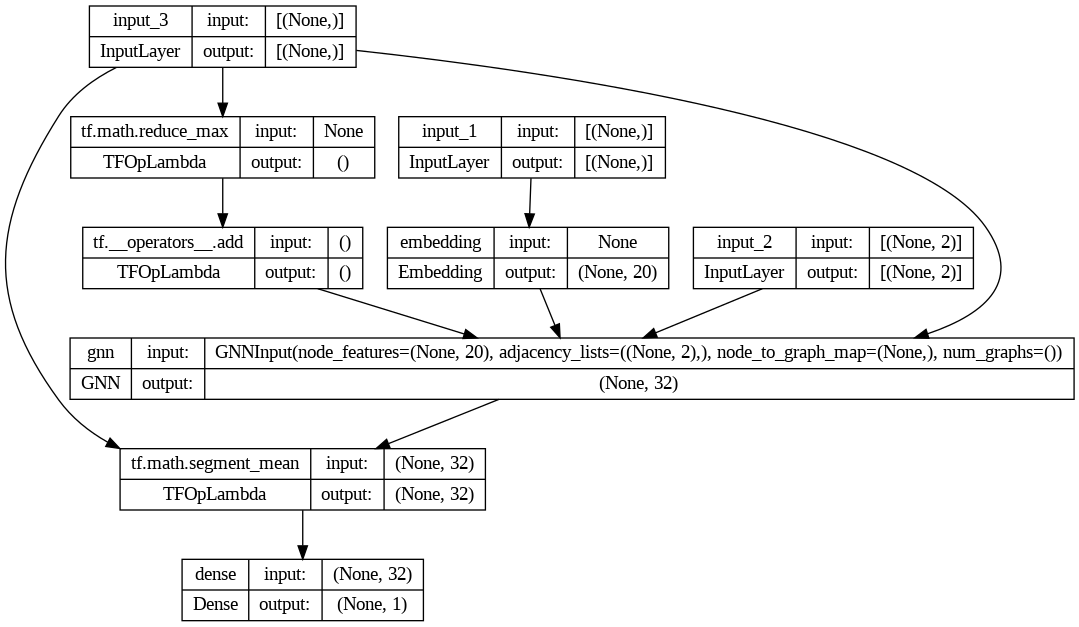

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [ ]:
model.compile(
    optimizer=Adam(learning_rate=1e-3),
    loss='BinaryCrossentropy',
    metrics=['AUC'],
)

In [ ]:
# defining early stop criteria
earlystop_callback =  keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, start_from_epoch = 3)

# defining learning rate scheduler
lr_reduction = ReduceLROnPlateau(monitor='val_loss',
                                patience=1,
                                verbose=1,
                                factor=0.2,
                                min_delta = 0.001,
                                min_lr=1e-5)

In [ ]:
%%time
import math

batch_size = 32
num_batchs = math.ceil(len(training_set) / batch_size) # number of training batches
num_batchs_validation = math.ceil(len(validation_set) / batch_size) # number of validation batches

model_2_hist = model.fit(
                gen_batch(training_set, batch_size=batch_size, repeat=True),
                steps_per_epoch=num_batchs,
                epochs=25,
                validation_data=gen_batch(
                validation_set, batch_size=16, repeat=True),
                validation_steps=num_batchs_validation,
                callbacks=[earlystop_callback, lr_reduction],
)

Epoch 1/25
1265/1265 [==============================] - 48s 29ms/step - loss: 0.6188 - auc: 0.7134 - val_loss: 0.8340 - val_auc: 0.7292 - lr: 0.0010
Epoch 2/25
1265/1265 [==============================] - 19s 15ms/step - loss: 0.5683 - auc: 0.7747 - val_loss: 0.6077 - val_auc: 0.8001 - lr: 0.0010
Epoch 3/25
1263/1265 [============================>.] - ETA: 0s - loss: 0.5459 - auc: 0.7969
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
1265/1265 [==============================] - 19s 15ms/step - loss: 0.5458 - auc: 0.7970 - val_loss: 0.7008 - val_auc: 0.8229 - lr: 0.0010
Epoch 4/25
1265/1265 [==============================] - ETA: 0s - loss: 0.5150 - auc: 0.8236
Epoch 4: ReduceLROnPlateau reducing learning rate to 4.0000001899898055e-05.
1265/1265 [==============================] - 19s 15ms/step - loss: 0.5150 - auc: 0.8236 - val_loss: 0.7234 - val_auc: 0.7866 - lr: 2.0000e-04
Epoch 5/25
1264/1265 [============================>.] - ETA: 0s - loss: 0.5064 - a

In [ ]:
model_2_hist.history.keys()

dict_keys(['loss', 'auc', 'val_loss', 'val_auc', 'lr'])

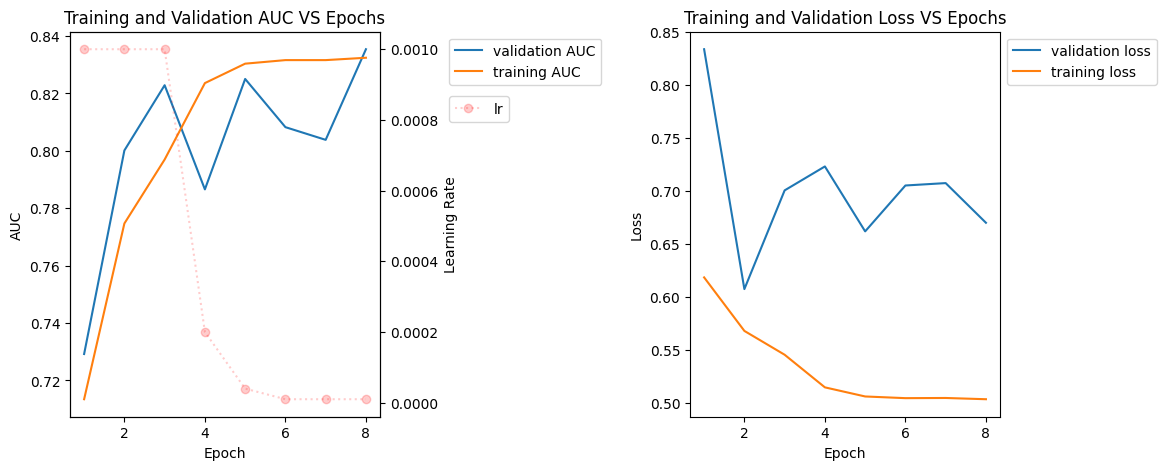

In [ ]:
# training converegence curves
model_history_plot(model_2_hist)

In [ ]:
y_pred = model.predict(
    gen_batch(testing_set, batch_size=batch_size, shuffle=False)
)
y_pred = np.reshape(y_pred, -1)

386/386 [==============================] - 2s 5ms/step


In [ ]:
len(y_pred)

12326

In [ ]:
import pandas as pd
submission = pd.DataFrame({'label':y_pred})
submission.index.name = 'id'
submission.to_csv('sample_submission_2.csv')

In [ ]:
import gc
del model
tf.keras.backend.clear_session()
gc.collect()

10906

## Model 3: Gated Graph Neural Networks - **GGNN**
**Setup:**
* Used Adam optimizer
* Used same batch size of 32 graphs/batch
* Used same GGNN message passing mechanism
* GNN number of layers 10
* changed dense intermediate layer actiavtion to relu
* added two fully connected layers (tanh) before the last o/p dense layer

**AUC Scores:**
* tr_auc: 0.8293,  val_auc: 0.8141
* private score: 0.79924, public score: 0.78949
* we guess that using large number of layers may have caused over-smoothing for the messages specifically the graphs are of chemical compounds so graphs are not huge so multiple updating can lead that all nodes will have similar messages
* we will try other message passing techniques and will return to the GGNN later on.

In [ ]:
data = keras.Input(batch_shape=(None,)) # features vector of nodes of dims -> (total_number_of_nodes_in_the_batch, number_dimensions_of_each_node which is 1 "one integer")
# where total_number_of_nodes_in_the_batch = batch_size * max_nodes_per_graph (if we do padding)

# the first dim is different to the previous one. it is the total number of edges in this batch
edge = keras.Input(batch_shape=(None, 2), dtype=tf.int32) # ajacenecy list of dims -> (number_of_edges_in_the_batch, 2)
# where 2 is because each entry in the adjacency list has 2 values (src,dst) nodes indicies


node2graph = keras.Input(batch_shape=(None,), dtype=tf.int32) # will have the same dimensions as the data -> (total_number_of_nodes_in_the_batch, 1)
# where 1 is because we have just the number of the graph to which the node belongs


embeded = Embedding(tokenizer.num_words, 20)(data) # converting the tokenized integer label of each node to a vector representation of length 20
# tokenizer.num_words --> max_vocab = 500 --> maximum number of unique nodes in all graphs --> 20*500 --> 10,000 weights to be learned
# embeded dims -> (batch_size * max_nodes_per_graph, 20) -> (total_number_of_nodes_in_the_batch, 20)

# number of graphs (number of samples) in the batch
num_graph = tf.reduce_max(node2graph)+1 # we add one because graph indicies are zero-indexed

gnn_input = GNNInput(
    node_features=embeded, # nodes features vector which is the embedded representation of the tokenized integer label of the chemical atom type
    adjacency_lists=(edge,), # passed as a tuple because we can pass different type of edges (different adjacency lists) for heterogeneous information networks
    node_to_graph_map=node2graph, # nodes graph indicies
    num_graphs=num_graph, # number of graphs in the batch
)

# https://github.com/microsoft/tf2-gnn/blob/master/tf2_gnn/layers/gnn.py
params = GNN.get_default_hyperparameters()
params["hidden_dim"] = 32 # each node will be represented as/will have a 32-vector message
params["message_calculation_class"] = 'GGNN'
params["dense_intermediate_layer_activation"] =  'relu'
params["num_layers"] = 10


gnn_layer = GNN(params)
gnn_out = gnn_layer(gnn_input) # output of GNN layer is of dims -> (batch_size * max_nodes_per_graph, hidden_dim) -> (total_number_of_nodes_in_the_batch, 32)

print('gnn_out', gnn_out)

# https://www.tensorflow.org/api_docs/python/tf/math/segment_mean
# Since our goal is to classify each individual graph we'll need to have a graph level representation rather than node-level ones
# So we need to aggregate the nodes of each graph, one way to do so is by using mean pooling using tf segment_mean function which will take averages of the specified segements
# avg will be of dims -> (batch_size, hidden_dim) -> (number_of_graphs_in_the_batch, 32)
avg = segment_mean(
    data=gnn_out,
    segment_ids=node2graph
)
print('mean:', avg)

# now we can use these graph-level representations in classification tasks using fully connected layers
fc_1 = Dense(32,activation='tanh')(avg)
fc_2 = Dense(16,activation='tanh')(fc_1)
pred = Dense(1, activation='sigmoid')(fc_2)
print('pred:', pred)

model = Model(
    inputs={
        'data': data,
        'edges': edge,
        'node2grah': node2graph,
    },
    outputs=pred
)
model.summary()

gnn_out KerasTensor(type_spec=TensorSpec(shape=(None, 32), dtype=tf.float32, name=None), name='gnn/StatefulPartitionedCall:0', description="created by layer 'gnn'")
mean: KerasTensor(type_spec=TensorSpec(shape=(None, 32), dtype=tf.float32, name=None), name='tf.math.segment_mean/SegmentMean:0', description="created by layer 'tf.math.segment_mean'")
pred: KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), name='dense_2/Sigmoid:0', description="created by layer 'dense_2'")
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None,)]            0           []                               
                                                                                                  
 input_1 (InputLayer)           [(None,)]            0           []                  

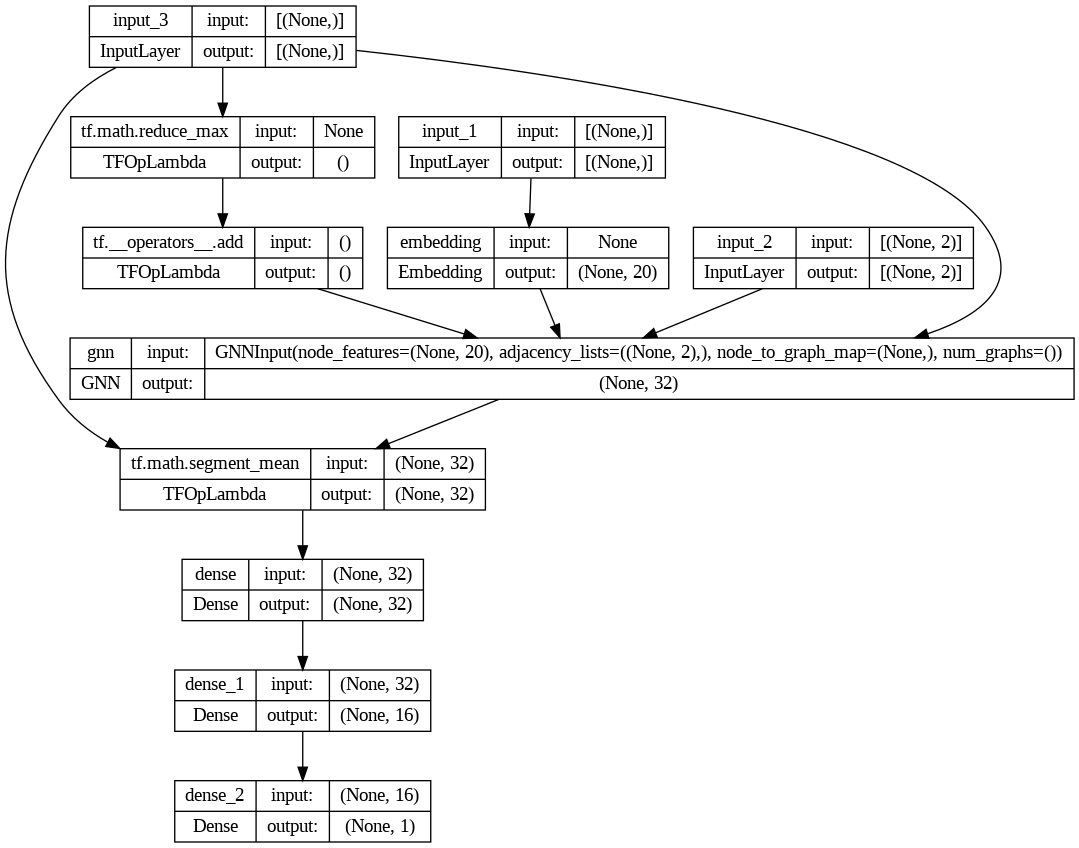

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [ ]:
model.compile(
    optimizer=Adam(learning_rate=1e-3),
    loss='BinaryCrossentropy',
    metrics=['AUC'],
)

In [ ]:
# defining early stop criteria
earlystop_callback =  keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, start_from_epoch = 8)

# defining learning rate scheduler
lr_reduction = ReduceLROnPlateau(monitor='val_loss',
                                patience=1,
                                verbose=1,
                                factor=0.2,
                                min_delta = 0.001,
                                min_lr=1e-6)

In [ ]:
%%time
import math

batch_size = 32
num_batchs = math.ceil(len(training_set) / batch_size) # number of training batches
num_batchs_validation = math.ceil(len(validation_set) / batch_size) # number of validation batches

model_3_hist = model.fit(
                gen_batch(training_set, batch_size=batch_size, repeat=True),
                steps_per_epoch=num_batchs,
                epochs=50,
                validation_data=gen_batch(
                validation_set, batch_size=batch_size, repeat=True),
                validation_steps=num_batchs_validation,
                callbacks=[earlystop_callback, lr_reduction],
)

Epoch 1/50
1265/1265 [==============================] - 76s 40ms/step - loss: 0.6318 - auc: 0.6947 - val_loss: 0.5890 - val_auc: 0.7510 - lr: 0.0010
Epoch 2/50
1265/1265 [==============================] - ETA: 0s - loss: 0.5742 - auc: 0.7698
Epoch 2: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
1265/1265 [==============================] - 50s 40ms/step - loss: 0.5742 - auc: 0.7698 - val_loss: 0.6042 - val_auc: 0.7847 - lr: 0.0010
Epoch 3/50
1265/1265 [==============================] - ETA: 0s - loss: 0.5291 - auc: 0.8125
Epoch 3: ReduceLROnPlateau reducing learning rate to 4.0000001899898055e-05.
1265/1265 [==============================] - 49s 39ms/step - loss: 0.5291 - auc: 0.8125 - val_loss: 0.6082 - val_auc: 0.8066 - lr: 2.0000e-04
Epoch 4/50
1265/1265 [==============================] - 49s 39ms/step - loss: 0.5162 - auc: 0.8233 - val_loss: 0.5760 - val_auc: 0.8064 - lr: 4.0000e-05
Epoch 5/50
1265/1265 [==============================] - ETA: 0s - loss: 0.5134

In [ ]:
model_3_hist.history.keys()

dict_keys(['loss', 'auc', 'val_loss', 'val_auc', 'lr'])

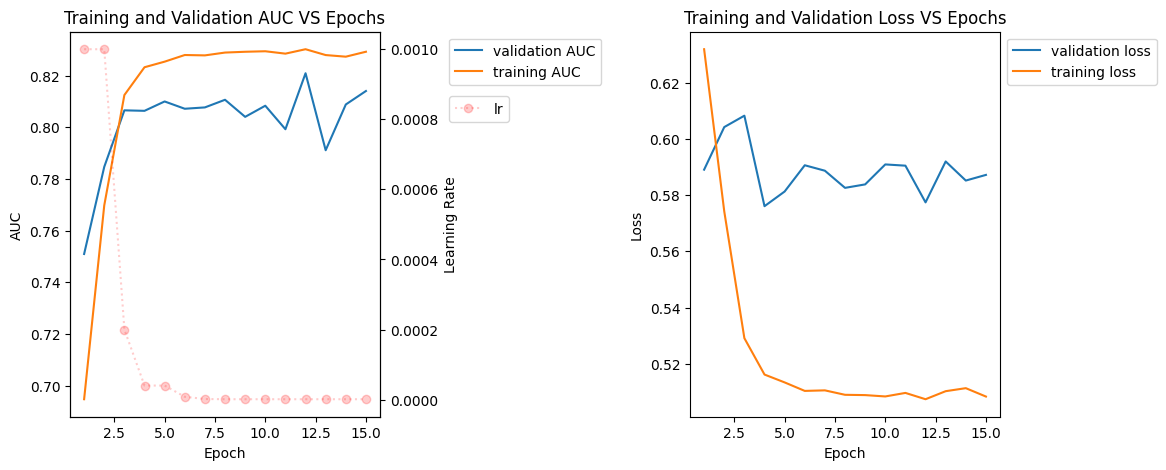

In [ ]:
# training converegence curves
model_history_plot(model_3_hist)

In [ ]:
y_pred = model.predict(
    gen_batch(testing_set, batch_size=batch_size, shuffle=False)
)
y_pred = np.reshape(y_pred, -1)

386/386 [==============================] - 4s 9ms/step


In [ ]:
len(y_pred)

12326

In [ ]:
import pandas as pd
submission = pd.DataFrame({'label':y_pred})
submission.index.name = 'id'
submission.to_csv('sample_submission_4.csv')

In [ ]:
import gc
del model
tf.keras.backend.clear_session()
gc.collect()

11325

## Model 4: Graph Neural Networks with Feature-wise Linear Modulation - **GNN_FiLM**

**Setup:**

* Used Adam optimizer
* Used same batch size of 32 graphs/batch
* Used GNN_FiLM message passing mechanism
* returned GNN number of layers to 3
* added two fully connected layers (tanh) before the last o/p dense layer

**AUC Scores:**
* tr_auc: 0.8615, val_auc: 0.8043
* private score: 0.80984, public score: 0.83491

**Message passing technique:**

The "Graph Neural Networks with Feature-wise Linear Modulation" - GNN_FiLM proposes a modified Graph Neural Network model with the following objectives:

* Improve expressiveness. The proposed model, called GNN_FiLM, allows feature-wise affine transformations in the graph neural network. This means it can scale and shift different dimensions of the node feature vectors differently. This makes the model more expressive than standard GNNs that only have a single linear transformation applied to all features.

* Learn dynamic node interactions. The affine feature transformations in GNN_FiLM are conditioned on neighbor node features. This allows the model to dynamically change how it aggregates information from each neighbor based on the neighbor's features. This can capture complex relationships between nodes.


So in summary, the main objectives of GNN_FiLM are:

- Improve the expressiveness of GNN models
- Learn dynamic node interactions based on node features

[Reference](https://arxiv.org/abs/1906.12192)

In [ ]:
data = keras.Input(batch_shape=(None,)) # features vector of nodes of dims -> (total_number_of_nodes_in_the_batch, number_dimensions_of_each_node which is 1 "one integer")
# where total_number_of_nodes_in_the_batch = batch_size * max_nodes_per_graph (if we do padding)

# the first dim is different to the previous one. it is the total number of edges in this batch
edge = keras.Input(batch_shape=(None, 2), dtype=tf.int32) # ajacenecy list of dims -> (number_of_edges_in_the_batch, 2)
# where 2 is because each entry in the adjacency list has 2 values (src,dst) nodes indicies


node2graph = keras.Input(batch_shape=(None,), dtype=tf.int32) # will have the same dimensions as the data -> (total_number_of_nodes_in_the_batch, 1)
# where 1 is because we have just the number of the graph to which the node belongs


embeded = Embedding(tokenizer.num_words, 20)(data) # converting the tokenized integer label of each node to a vector representation of length 20
# tokenizer.num_words --> max_vocab = 500 --> maximum number of unique nodes in all graphs --> 20*500 --> 10,000 weights to be learned
# embeded dims -> (batch_size * max_nodes_per_graph, 20) -> (total_number_of_nodes_in_the_batch, 20)

# number of graphs (number of samples) in the batch
num_graph = tf.reduce_max(node2graph)+1 # we add one because graph indicies are zero-indexed

gnn_input = GNNInput(
    node_features=embeded, # nodes features vector which is the embedded representation of the tokenized integer label of the chemical atom type
    adjacency_lists=(edge,), # passed as a tuple because we can pass different type of edges (different adjacency lists) for heterogeneous information networks
    node_to_graph_map=node2graph, # nodes graph indicies
    num_graphs=num_graph, # number of graphs in the batch
)

# https://github.com/microsoft/tf2-gnn/blob/master/tf2_gnn/layers/gnn.py
params = GNN.get_default_hyperparameters()
params["hidden_dim"] = 32 # each node will be represented as/will have a 32-vector message
params["message_calculation_class"] = 'GNN_FiLM'
params["num_layers"] = 3
params["num_aggr_MLP_hidden_layers"] = 3
params["num_edge_MLP_hidden_layers"] = 3
params["film_parameter_MLP_hidden_layers"] = 1


gnn_layer = GNN(params)
gnn_out = gnn_layer(gnn_input) # output of GNN layer is of dims -> (batch_size * max_nodes_per_graph, hidden_dim) -> (total_number_of_nodes_in_the_batch, 32)

print('gnn_out', gnn_out)

# https://www.tensorflow.org/api_docs/python/tf/math/segment_mean
# Since our goal is to classify each individual graph we'll need to have a graph level representation rather than node-level ones
# So we need to aggregate the nodes of each graph, one way to do so is by using mean pooling using tf segment_mean function which will take averages of the specified segements
# avg will be of dims -> (batch_size, hidden_dim) -> (number_of_graphs_in_the_batch, 32)
avg = segment_mean(
    data=gnn_out,
    segment_ids=node2graph
)
print('mean:', avg)

# now we can use these graph-level representations in classification tasks using fully connected layers
fc_1 = Dense(512,activation='tanh')(avg)
fc_2 = Dense(64,activation='tanh')(fc_1)
pred = Dense(1, activation='sigmoid')(fc_2)
print('pred:', pred)

model = Model(
    inputs={
        'data': data,
        'edges': edge,
        'node2grah': node2graph,
    },
    outputs=pred
)
model.summary()

gnn_out KerasTensor(type_spec=TensorSpec(shape=(None, 32), dtype=tf.float32, name=None), name='gnn/StatefulPartitionedCall:0', description="created by layer 'gnn'")
mean: KerasTensor(type_spec=TensorSpec(shape=(None, 32), dtype=tf.float32, name=None), name='tf.math.segment_mean/SegmentMean:0', description="created by layer 'tf.math.segment_mean'")
pred: KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), name='dense_2/Sigmoid:0', description="created by layer 'dense_2'")
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None,)]            0           []                               
                                                                                                  
 input_1 (InputLayer)           [(None,)]            0           []                  

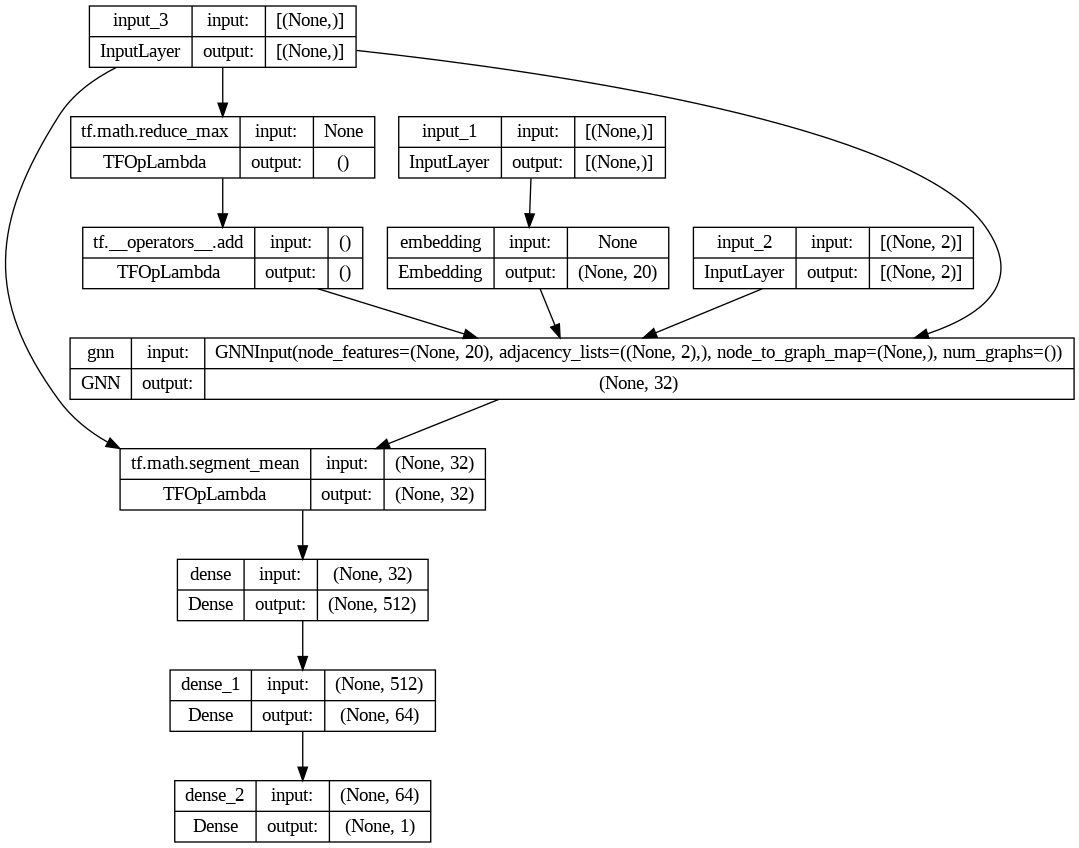

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [ ]:
model.compile(
    optimizer=Adam(learning_rate=1e-3),
    loss='BinaryCrossentropy',
    metrics=['AUC'],
)

In [ ]:
# defining early stop criteria
earlystop_callback =  keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, start_from_epoch = 8)

# defining learning rate scheduler
lr_reduction = ReduceLROnPlateau(monitor='val_loss',
                                patience=1,
                                verbose=1,
                                factor=0.2,
                                min_delta = 0.001,
                                min_lr=1e-6)

In [ ]:
%%time
import math

batch_size = 32
num_batchs = math.ceil(len(training_set) / batch_size) # number of training batches
num_batchs_validation = math.ceil(len(validation_set) / batch_size) # number of validation batches

model_3_hist = model.fit(
                gen_batch(training_set, batch_size=batch_size, repeat=True),
                steps_per_epoch=num_batchs,
                epochs=50,
                validation_data=gen_batch(
                validation_set, batch_size=batch_size, repeat=True),
                validation_steps=num_batchs_validation,
                callbacks=[earlystop_callback, lr_reduction],
)

Epoch 1/50
1265/1265 [==============================] - 29s 18ms/step - loss: 0.6182 - auc: 0.7062 - val_loss: 0.6852 - val_auc: 0.7444 - lr: 0.0010
Epoch 2/50
1265/1265 [==============================] - ETA: 0s - loss: 0.5647 - auc: 0.7768
Epoch 2: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
1265/1265 [==============================] - 22s 17ms/step - loss: 0.5647 - auc: 0.7768 - val_loss: 0.7002 - val_auc: 0.7795 - lr: 0.0010
Epoch 3/50
1265/1265 [==============================] - 22s 17ms/step - loss: 0.5272 - auc: 0.8144 - val_loss: 0.5948 - val_auc: 0.7841 - lr: 2.0000e-04
Epoch 4/50
1265/1265 [==============================] - 20s 16ms/step - loss: 0.5119 - auc: 0.8273 - val_loss: 0.5914 - val_auc: 0.8095 - lr: 2.0000e-04
Epoch 5/50
1265/1265 [==============================] - 21s 16ms/step - loss: 0.5033 - auc: 0.8339 - val_loss: 0.5209 - val_auc: 0.8090 - lr: 2.0000e-04
Epoch 6/50
1265/1265 [==============================] - 20s 15ms/step - loss: 0.4950

In [ ]:
model_3_hist.history.keys()

dict_keys(['loss', 'auc', 'val_loss', 'val_auc', 'lr'])

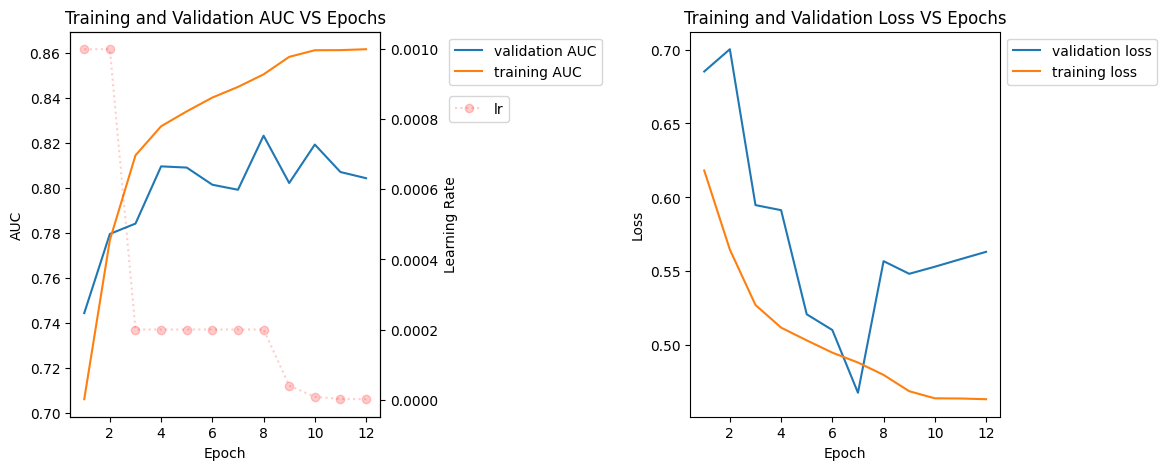

In [ ]:
# training converegence curves
model_history_plot(model_3_hist)

In [ ]:
y_pred = model.predict(
    gen_batch(testing_set, batch_size=batch_size, shuffle=False)
)
y_pred = np.reshape(y_pred, -1)

386/386 [==============================] - 3s 5ms/step


In [ ]:
len(y_pred)

12326

In [ ]:
import pandas as pd
submission = pd.DataFrame({'label':y_pred})
submission.index.name = 'id'
submission.to_csv('sample_submission_3.csv')

In [ ]:
import gc
del model
tf.keras.backend.clear_session()
gc.collect()

11327

## Model 5: Relational Graph Convolutional Networks - **RGCN**
**Setup:**
* Used Adam optimizer
* Used same batch size of 32 graphs/batch
* Used RGCN message passing mechanism
* returned GNN number of layers to 5
* changed dense intermediate layer actiavtion to relu
* added one fully connected layers (relu) before the last o/p dense layer

**AUC Scores:**
* tr_auc: 0.7659, val_auc: 0.7436
* private score: 0.74219, public score: 0.72272
* the model is clearly underfiting and this can return to the message passing technique used as it is resposible for the graph level vector that will be given to the dense layer so we guess this GNN message aggregation technique is not capturing the appropriate amount of information needed for graph classification
* next we will assess another message passing technique.

**Message passing technique:**

The "Relational Graph Convolutional Networks" - RGCN have the followig characteristics:
- Incorporate relational reasoning into Graph Neural Networks. Standard GNNs only consider node features and the graph structure. RGCN also incorporates the types of relationships between nodes (edges) and relation-specific weights. This allows for relational reasoning.

- Generalize across relations. RGCN shares parameters across relation types, which allows it to learn generally useful aggregation functions that can apply to new or unseen relation types. This is unlike models that have relation-specific parameters.

- Scale to large, sparse graphs with many relation types. RGCN has a runtime complexity linear in the number of edges, and space complexity linear in the number of relations. So it can scale to very large graphs with many relations.

So in summary RGCN provide:

- Enable relational reasoning in Graph Neural Networks
- Share parameters across relations to enable generalization
- Achieve scalability to large, sparse graphs with many relations

[Reference](https://arxiv.org/pdf/1703.06103.pdf)

In [ ]:
data = keras.Input(batch_shape=(None,)) # features vector of nodes of dims -> (total_number_of_nodes_in_the_batch, number_dimensions_of_each_node which is 1 "one integer")
# where total_number_of_nodes_in_the_batch = batch_size * max_nodes_per_graph (if we do padding)

# the first dim is different to the previous one. it is the total number of edges in this batch
edge = keras.Input(batch_shape=(None, 2), dtype=tf.int32) # ajacenecy list of dims -> (number_of_edges_in_the_batch, 2)
# where 2 is because each entry in the adjacency list has 2 values (src,dst) nodes indicies


node2graph = keras.Input(batch_shape=(None,), dtype=tf.int32) # will have the same dimensions as the data -> (total_number_of_nodes_in_the_batch, 1)
# where 1 is because we have just the number of the graph to which the node belongs


embeded = Embedding(tokenizer.num_words, 20)(data) # converting the tokenized integer label of each node to a vector representation of length 20
# tokenizer.num_words --> max_vocab = 500 --> maximum number of unique nodes in all graphs --> 20*500 --> 10,000 weights to be learned
# embeded dims -> (batch_size * max_nodes_per_graph, 20) -> (total_number_of_nodes_in_the_batch, 20)

# number of graphs (number of samples) in the batch
num_graph = tf.reduce_max(node2graph)+1 # we add one because graph indicies are zero-indexed

gnn_input = GNNInput(
    node_features=embeded, # nodes features vector which is the embedded representation of the tokenized integer label of the chemical atom type
    adjacency_lists=(edge,), # passed as a tuple because we can pass different type of edges (different adjacency lists) for heterogeneous information networks
    node_to_graph_map=node2graph, # nodes graph indicies
    num_graphs=num_graph, # number of graphs in the batch
)

# https://github.com/microsoft/tf2-gnn/blob/master/tf2_gnn/layers/gnn.py
params = GNN.get_default_hyperparameters()
params["hidden_dim"] = 32 # each node will be represented as/will have a 32-vector message
params["message_calculation_class"] = 'RGCN'
params["num_layers"] = 5
params["dense_intermediate_layer_activation"] = 'relu'

gnn_layer = GNN(params)
gnn_out = gnn_layer(gnn_input) # output of GNN layer is of dims -> (batch_size * max_nodes_per_graph, hidden_dim) -> (total_number_of_nodes_in_the_batch, 32)

print('gnn_out', gnn_out)

# https://www.tensorflow.org/api_docs/python/tf/math/segment_mean
# Since our goal is to classify each individual graph we'll need to have a graph level representation rather than node-level ones
# So we need to aggregate the nodes of each graph, one way to do so is by using mean pooling using tf segment_mean function which will take averages of the specified segements
# avg will be of dims -> (batch_size, hidden_dim) -> (number_of_graphs_in_the_batch, 32)
avg = segment_mean(
    data=gnn_out,
    segment_ids=node2graph
)
print('mean:', avg)

# now we can use these graph-level representations in classification tasks using fully connected layers
fc_1 = Dense(32,activation='relu')(avg)
pred = Dense(1, activation='sigmoid')(fc_1)
print('pred:', pred)

model = Model(
    inputs={
        'data': data,
        'edges': edge,
        'node2grah': node2graph,
    },
    outputs=pred
)
model.summary()

gnn_out KerasTensor(type_spec=TensorSpec(shape=(None, 32), dtype=tf.float32, name=None), name='gnn/StatefulPartitionedCall:0', description="created by layer 'gnn'")
mean: KerasTensor(type_spec=TensorSpec(shape=(None, 32), dtype=tf.float32, name=None), name='tf.math.segment_mean/SegmentMean:0', description="created by layer 'tf.math.segment_mean'")
pred: KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), name='dense_1/Sigmoid:0', description="created by layer 'dense_1'")
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None,)]            0           []                               
                                                                                                  
 input_1 (InputLayer)           [(None,)]            0           []                  

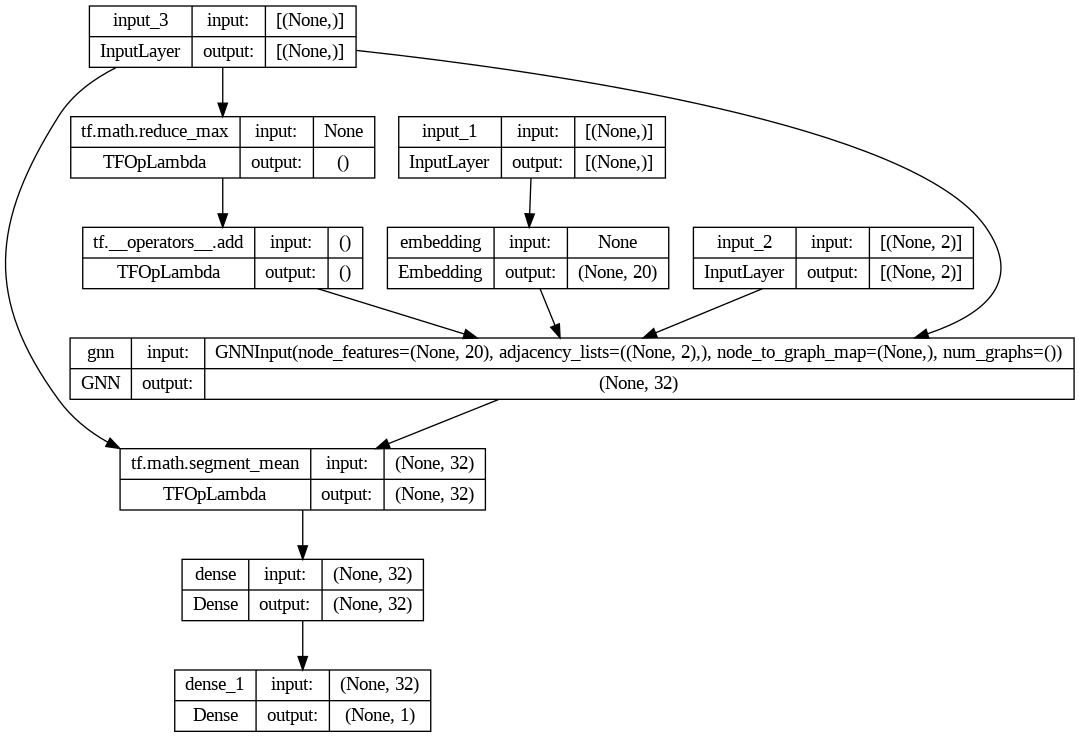

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [ ]:
model.compile(
    optimizer=Adam(learning_rate=1e-3),
    loss='BinaryCrossentropy',
    metrics=['AUC'],
)

In [ ]:
# defining early stop criteria
earlystop_callback =  keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, start_from_epoch = 8)

# defining learning rate scheduler
lr_reduction = ReduceLROnPlateau(monitor='val_loss',
                                patience=1,
                                verbose=1,
                                factor=0.2,
                                min_delta = 0.001,
                                min_lr=1e-6)

In [ ]:
%%time
import math

batch_size = 32
num_batchs = math.ceil(len(training_set) / batch_size) # number of training batches
num_batchs_validation = math.ceil(len(validation_set) / batch_size) # number of validation batches

model_5_hist = model.fit(
                gen_batch(training_set, batch_size=batch_size, repeat=True),
                steps_per_epoch=num_batchs,
                epochs=50,
                validation_data=gen_batch(
                validation_set, batch_size=batch_size, repeat=True),
                validation_steps=num_batchs_validation,
                callbacks=[earlystop_callback, lr_reduction],
)

Epoch 1/50
1265/1265 [==============================] - 32s 20ms/step - loss: 0.6242 - auc: 0.7037 - val_loss: 0.6496 - val_auc: 0.7301 - lr: 0.0010
Epoch 2/50
1265/1265 [==============================] - 24s 19ms/step - loss: 0.5976 - auc: 0.7382 - val_loss: 0.6250 - val_auc: 0.7451 - lr: 0.0010
Epoch 3/50
1264/1265 [============================>.] - ETA: 0s - loss: 0.5903 - auc: 0.7466
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
1265/1265 [==============================] - 24s 19ms/step - loss: 0.5902 - auc: 0.7467 - val_loss: 0.6472 - val_auc: 0.7483 - lr: 0.0010
Epoch 4/50
1265/1265 [==============================] - ETA: 0s - loss: 0.5794 - auc: 0.7605
Epoch 4: ReduceLROnPlateau reducing learning rate to 4.0000001899898055e-05.
1265/1265 [==============================] - 23s 18ms/step - loss: 0.5794 - auc: 0.7605 - val_loss: 0.6695 - val_auc: 0.7463 - lr: 2.0000e-04
Epoch 5/50
1265/1265 [==============================] - ETA: 0s - loss: 0.5771 - a

In [ ]:
model_5_hist.history.keys()

dict_keys(['loss', 'auc', 'val_loss', 'val_auc', 'lr'])

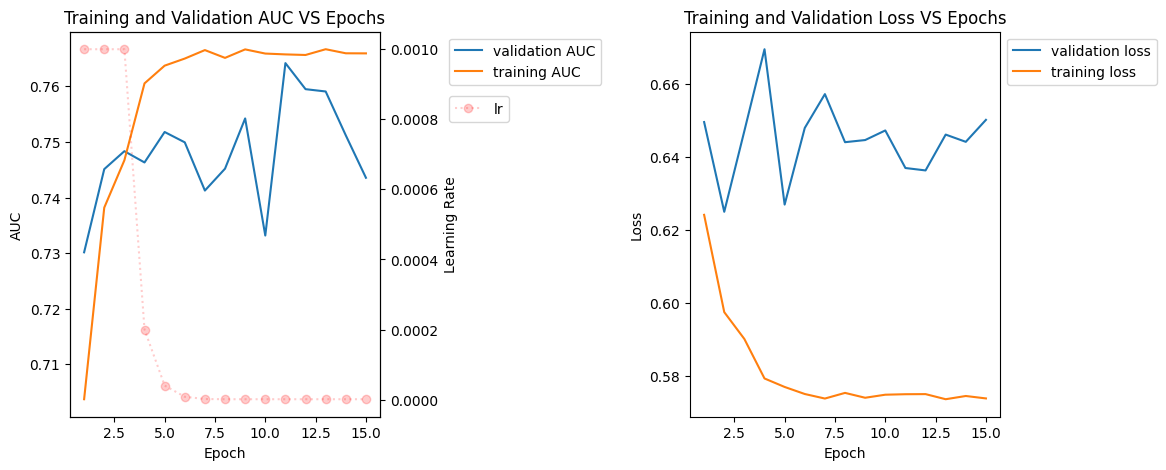

In [ ]:
# training converegence curves
model_history_plot(model_3_hist)

In [ ]:
y_pred = model.predict(
    gen_batch(testing_set, batch_size=batch_size, shuffle=False)
)
y_pred = np.reshape(y_pred, -1)

386/386 [==============================] - 6s 10ms/step


In [ ]:
len(y_pred)

12326

In [ ]:
import pandas as pd
submission = pd.DataFrame({'label':y_pred})
submission.index.name = 'id'
submission.to_csv('sample_submission_5.csv')

In [ ]:
import gc
del model
tf.keras.backend.clear_session()
gc.collect()

24786

## Model 6: Relational Graph Attention Networks - **RGAT**
Since model 2 settings lead to best score so far we will fix it settings except for message passing techniques and will try RGAT rather than GGNN.

* Used Adam optimizer
* Used same batch size of 32 graphs/batch
* Used RGAT message passing mechanism
* GNN number of layers 3
* set "num_heads" which configures the number of parallel (independent) weighted sums that are computed, whose results are concatenated to obtain the final result to be 8.

**AUC Scores:**
* tr_auc: 0.7884, val_auc: 0.8010
* private score: 0.76434, public score: 0.76418
* the same as RGCN, RGAT is underfitting and appears to be not being able to obtain the needed/appropriate amount of information as GGNN technique

**Message passing technique:**

- “Relational Graph Attention Networks” proposes a class of models that extends non-relational graph attention mechanisms to incorporate relational information, opening up these methods to a wider variety of problems.
- Relational Graph Attention Networks RGAT focus on modelling multi-relational graphs that contain entities with directed links of different labels (e.g., knowledge graphs)
- The objective of RGAT is to deal with more general and complex multi-relational graphs that contain entities with directed links of different labels.

[Reference](https://arxiv.org/pdf/1710.10903.pdf)

In [ ]:
data = keras.Input(batch_shape=(None,)) # features vector of nodes of dims -> (total_number_of_nodes_in_the_batch, number_dimensions_of_each_node which is 1 "one integer")
# where total_number_of_nodes_in_the_batch = batch_size * max_nodes_per_graph (if we do padding)

# the first dim is different to the previous one. it is the total number of edges in this batch
edge = keras.Input(batch_shape=(None, 2), dtype=tf.int32) # ajacenecy list of dims -> (number_of_edges_in_the_batch, 2)
# where 2 is because each entry in the adjacency list has 2 values (src,dst) nodes indicies


node2graph = keras.Input(batch_shape=(None,), dtype=tf.int32) # will have the same dimensions as the data -> (total_number_of_nodes_in_the_batch, 1)
# where 1 is because we have just the number of the graph to which the node belongs


embeded = Embedding(tokenizer.num_words, 20)(data) # converting the tokenized integer label of each node to a vector representation of length 20
# tokenizer.num_words --> max_vocab = 500 --> maximum number of unique nodes in all graphs --> 20*500 --> 10,000 weights to be learned
# embeded dims -> (batch_size * max_nodes_per_graph, 20) -> (total_number_of_nodes_in_the_batch, 20)

# number of graphs (number of samples) in the batch
num_graph = tf.reduce_max(node2graph)+1 # we add one because graph indicies are zero-indexed

gnn_input = GNNInput(
    node_features=embeded, # nodes features vector which is the embedded representation of the tokenized integer label of the chemical atom type
    adjacency_lists=(edge,), # passed as a tuple because we can pass different type of edges (different adjacency lists) for heterogeneous information networks
    node_to_graph_map=node2graph, # nodes graph indicies
    num_graphs=num_graph, # number of graphs in the batch
)

# https://github.com/microsoft/tf2-gnn/blob/master/tf2_gnn/layers/gnn.py
params = GNN.get_default_hyperparameters()
params["hidden_dim"] = 32 # each node will be represented as/will have a 32-vector message
params["message_calculation_class"] = 'RGAT'
params["num_heads"] = 8
params["num_layers"] = 3


gnn_layer = GNN(params)
gnn_out = gnn_layer(gnn_input) # output of GNN layer is of dims -> (batch_size * max_nodes_per_graph, hidden_dim) -> (total_number_of_nodes_in_the_batch, 32)

print('gnn_out', gnn_out)

# https://www.tensorflow.org/api_docs/python/tf/math/segment_mean
# Since our goal is to classify each individual graph we'll need to have a graph level representation rather than node-level ones
# So we need to aggregate the nodes of each graph, one way to do so is by using mean pooling using tf segment_mean function which will take averages of the specified segements
# avg will be of dims -> (batch_size, hidden_dim) -> (number_of_graphs_in_the_batch, 32)
avg = segment_mean(
    data=gnn_out,
    segment_ids=node2graph
)
print('mean:', avg)

# now we can use these graph-level representations in classification tasks using fully connected layers
pred = Dense(1, activation='sigmoid')(avg)
print('pred:', pred)

model = Model(
    inputs={
        'data': data,
        'edges': edge,
        'node2grah': node2graph,
    },
    outputs=pred
)
model.summary()

gnn_out KerasTensor(type_spec=TensorSpec(shape=(None, 32), dtype=tf.float32, name=None), name='gnn_1/StatefulPartitionedCall:0', description="created by layer 'gnn_1'")
mean: KerasTensor(type_spec=TensorSpec(shape=(None, 32), dtype=tf.float32, name=None), name='tf.math.segment_mean/SegmentMean:0', description="created by layer 'tf.math.segment_mean'")
pred: KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), name='dense/Sigmoid:0', description="created by layer 'dense'")
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None,)]            0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None,)]            0           []                  

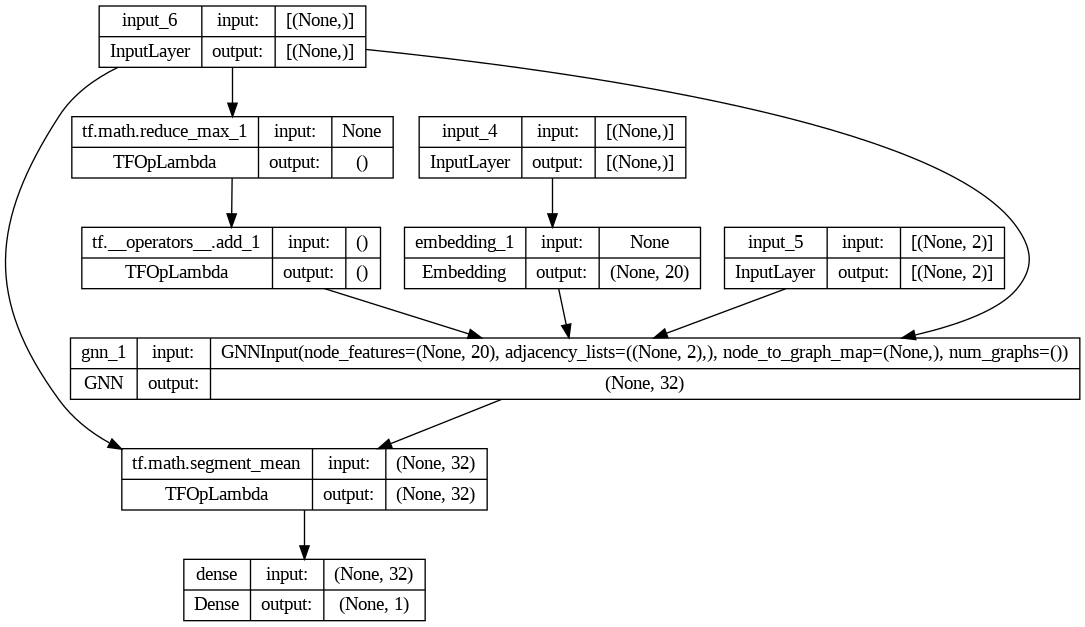

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [ ]:
model.compile(
    optimizer=Adam(learning_rate=1e-3),
    loss='BinaryCrossentropy',
    metrics=['AUC'],
)

In [ ]:
# defining early stop criteria
earlystop_callback =  keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, start_from_epoch = 8)

# defining learning rate scheduler
lr_reduction = ReduceLROnPlateau(monitor='val_loss',
                                patience=1,
                                verbose=1,
                                factor=0.2,
                                min_delta = 0.001,
                                min_lr=1e-6)

In [ ]:
%%time
import math

batch_size = 32
num_batchs = math.ceil(len(training_set) / batch_size) # number of training batches
num_batchs_validation = math.ceil(len(validation_set) / batch_size) # number of validation batches

model_6_hist = model.fit(
                gen_batch(training_set, batch_size=batch_size, repeat=True),
                steps_per_epoch=num_batchs,
                epochs=25,
                validation_data=gen_batch(
                validation_set, batch_size=16, repeat=True),
                validation_steps=num_batchs_validation,
                callbacks=[earlystop_callback, lr_reduction],
)

Epoch 1/25
1265/1265 [==============================] - 57s 33ms/step - loss: 0.6278 - auc: 0.6978 - val_loss: 0.7652 - val_auc: 0.7294 - lr: 0.0010
Epoch 2/25
1265/1265 [==============================] - 37s 29ms/step - loss: 0.6038 - auc: 0.7305 - val_loss: 0.7314 - val_auc: 0.7512 - lr: 0.0010
Epoch 3/25
1265/1265 [==============================] - ETA: 0s - loss: 0.5851 - auc: 0.7534
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
1265/1265 [==============================] - 35s 28ms/step - loss: 0.5851 - auc: 0.7534 - val_loss: 0.7839 - val_auc: 0.7891 - lr: 0.0010
Epoch 4/25
1265/1265 [==============================] - 36s 28ms/step - loss: 0.5612 - auc: 0.7797 - val_loss: 0.6321 - val_auc: 0.7484 - lr: 2.0000e-04
Epoch 5/25
1264/1265 [============================>.] - ETA: 0s - loss: 0.5573 - auc: 0.7839
Epoch 5: ReduceLROnPlateau reducing learning rate to 4.0000001899898055e-05.
1265/1265 [==============================] - 37s 30ms/step - loss: 0.55

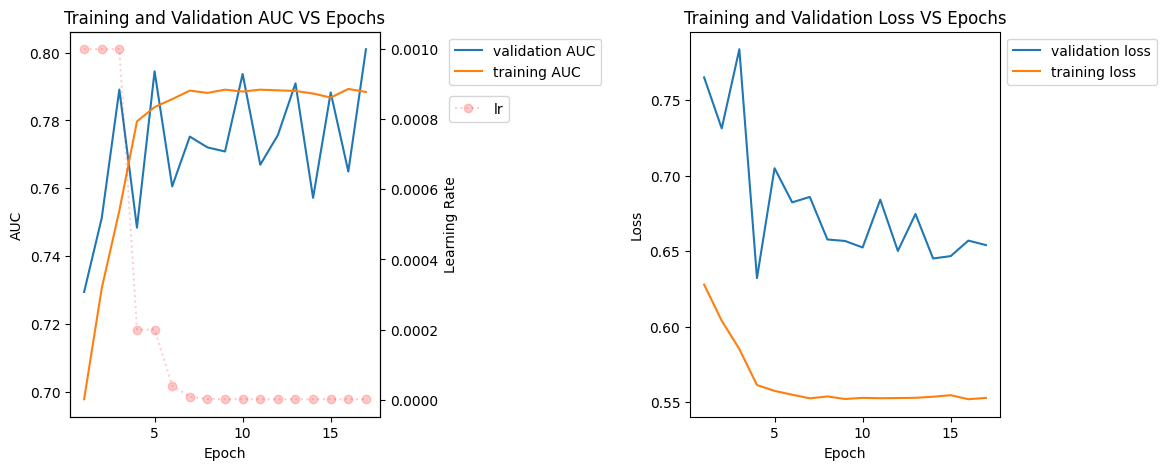

In [ ]:
# training converegence curves
model_history_plot(model_6_hist)

In [ ]:
y_pred = model.predict(
    gen_batch(testing_set, batch_size=batch_size, shuffle=False)
)
y_pred = np.reshape(y_pred, -1)

386/386 [==============================] - 3s 7ms/step


In [ ]:
len(y_pred)

12326

In [ ]:
import pandas as pd
submission = pd.DataFrame({'label':y_pred})
submission.index.name = 'id'
submission.to_csv('sample_submission_6.csv')

In [ ]:
import gc
del model
tf.keras.backend.clear_session()
gc.collect()

29370

## Model 7: Graph Neural Network with Edge MLPs - **GNN-Edge-MLP**
Same as model 6, since model 2 settings lead to best score so far we will fix it settings except for message passing techniques and will try GNN_Edge_MLP rather than GGNN.
* Used Adam optimizer
* Used same batch size of 32 graphs/batch
* Used GNN-Edge-MLP message passing mechanism
* GNN number of layers 3

**AUC Scores:**
* auc: 0.7946, val_auc: 0.7719
* private score: 0.76598, public score: 0.76925
* this technique also underfits the data. we are sure that the message passing technique is the root cause of this underfitting as same model configuration is used with GGNN and lead to higher results.
* since GGNN technique is the best performer so far we will focus on it during the next trials, trying different hyperparameters to see how can we improve the performance futher.

**Message passing technique:**

Graph Neural Network with Edge MLPs - a variant of RGCN in which messages on edges are computed using full MLPs, not just a single layer applied to the source state.

[Reference](https://github.com/microsoft/tf2-gnn)

In [ ]:
data = keras.Input(batch_shape=(None,)) # features vector of nodes of dims -> (total_number_of_nodes_in_the_batch, number_dimensions_of_each_node which is 1 "one integer")
# where total_number_of_nodes_in_the_batch = batch_size * max_nodes_per_graph (if we do padding)

# the first dim is different to the previous one. it is the total number of edges in this batch
edge = keras.Input(batch_shape=(None, 2), dtype=tf.int32) # ajacenecy list of dims -> (number_of_edges_in_the_batch, 2)
# where 2 is because each entry in the adjacency list has 2 values (src,dst) nodes indicies


node2graph = keras.Input(batch_shape=(None,), dtype=tf.int32) # will have the same dimensions as the data -> (total_number_of_nodes_in_the_batch, 1)
# where 1 is because we have just the number of the graph to which the node belongs


embeded = Embedding(tokenizer.num_words, 20)(data) # converting the tokenized integer label of each node to a vector representation of length 20
# tokenizer.num_words --> max_vocab = 500 --> maximum number of unique nodes in all graphs --> 20*500 --> 10,000 weights to be learned
# embeded dims -> (batch_size * max_nodes_per_graph, 20) -> (total_number_of_nodes_in_the_batch, 20)

# number of graphs (number of samples) in the batch
num_graph = tf.reduce_max(node2graph)+1 # we add one because graph indicies are zero-indexed

gnn_input = GNNInput(
    node_features=embeded, # nodes features vector which is the embedded representation of the tokenized integer label of the chemical atom type
    adjacency_lists=(edge,), # passed as a tuple because we can pass different type of edges (different adjacency lists) for heterogeneous information networks
    node_to_graph_map=node2graph, # nodes graph indicies
    num_graphs=num_graph, # number of graphs in the batch
)

# https://github.com/microsoft/tf2-gnn/blob/master/tf2_gnn/layers/gnn.py
params = GNN.get_default_hyperparameters()
params["hidden_dim"] = 32 # each node will be represented as/will have a 32-vector message
params["message_calculation_class"] = 'GNN_Edge_MLP'
params["num_layers"] = 3

gnn_layer = GNN(params)
gnn_out = gnn_layer(gnn_input) # output of GNN layer is of dims -> (batch_size * max_nodes_per_graph, hidden_dim) -> (total_number_of_nodes_in_the_batch, 32)

print('gnn_out', gnn_out)

# https://www.tensorflow.org/api_docs/python/tf/math/segment_mean
# Since our goal is to classify each individual graph we'll need to have a graph level representation rather than node-level ones
# So we need to aggregate the nodes of each graph, one way to do so is by using mean pooling using tf segment_mean function which will take averages of the specified segements
# avg will be of dims -> (batch_size, hidden_dim) -> (number_of_graphs_in_the_batch, 32)
avg = segment_mean(
    data=gnn_out,
    segment_ids=node2graph
)
print('mean:', avg)

# now we can use these graph-level representations in classification tasks using fully connected layers
pred = Dense(1, activation='sigmoid')(avg)
print('pred:', pred)

model = Model(
    inputs={
        'data': data,
        'edges': edge,
        'node2grah': node2graph,
    },
    outputs=pred
)
model.summary()

gnn_out KerasTensor(type_spec=TensorSpec(shape=(None, 32), dtype=tf.float32, name=None), name='gnn/StatefulPartitionedCall:0', description="created by layer 'gnn'")
mean: KerasTensor(type_spec=TensorSpec(shape=(None, 32), dtype=tf.float32, name=None), name='tf.math.segment_mean/SegmentMean:0', description="created by layer 'tf.math.segment_mean'")
pred: KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), name='dense/Sigmoid:0', description="created by layer 'dense'")
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None,)]            0           []                               
                                                                                                  
 input_1 (InputLayer)           [(None,)]            0           []                      

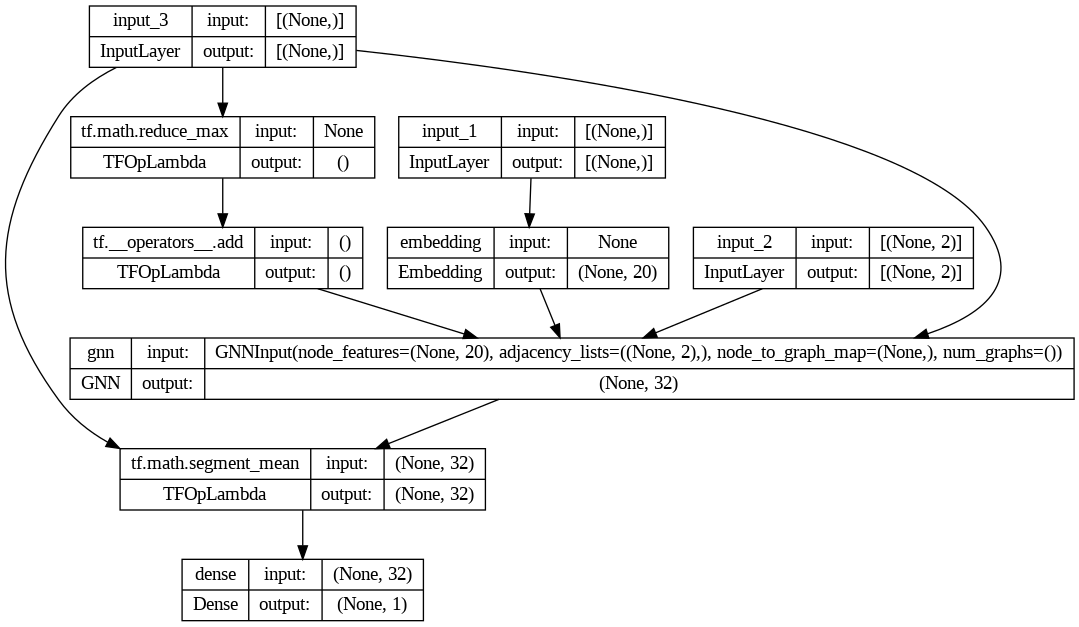

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [ ]:
model.compile(
    optimizer=Adam(learning_rate=1e-3),
    loss='BinaryCrossentropy',
    metrics=['AUC'],
)

In [ ]:
# defining early stop criteria
earlystop_callback =  keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, start_from_epoch = 8)

# defining learning rate scheduler
lr_reduction = ReduceLROnPlateau(monitor='val_loss',
                                patience=1,
                                verbose=1,
                                factor=0.2,
                                min_delta = 0.001,
                                min_lr=1e-6)

In [ ]:
%%time
import math

batch_size = 32
num_batchs = math.ceil(len(training_set) / batch_size) # number of training batches
num_batchs_validation = math.ceil(len(validation_set) / batch_size) # number of validation batches

model_7_hist = model.fit(
                gen_batch(training_set, batch_size=batch_size, repeat=True),
                steps_per_epoch=num_batchs,
                epochs=30,
                validation_data=gen_batch(
                validation_set, batch_size=batch_size, repeat=True),
                validation_steps=num_batchs_validation,
                callbacks=[earlystop_callback, lr_reduction],
)

Epoch 1/30
1265/1265 [==============================] - 20s 16ms/step - loss: 0.6130 - auc: 0.7211 - val_loss: 0.8130 - val_auc: 0.7295 - lr: 0.0010
Epoch 2/30
1265/1265 [==============================] - 16s 13ms/step - loss: 0.5878 - auc: 0.7505 - val_loss: 0.6226 - val_auc: 0.7568 - lr: 0.0010
Epoch 3/30
1265/1265 [==============================] - 16s 12ms/step - loss: 0.5716 - auc: 0.7693 - val_loss: 0.5811 - val_auc: 0.7717 - lr: 0.0010
Epoch 4/30
1265/1265 [==============================] - ETA: 0s - loss: 0.5674 - auc: 0.7746
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
1265/1265 [==============================] - 19s 15ms/step - loss: 0.5674 - auc: 0.7746 - val_loss: 0.7004 - val_auc: 0.7746 - lr: 0.0010
Epoch 5/30
1264/1265 [============================>.] - ETA: 0s - loss: 0.5536 - auc: 0.7883
Epoch 5: ReduceLROnPlateau reducing learning rate to 4.0000001899898055e-05.
1265/1265 [==============================] - 28s 22ms/step - loss: 0.5536 -

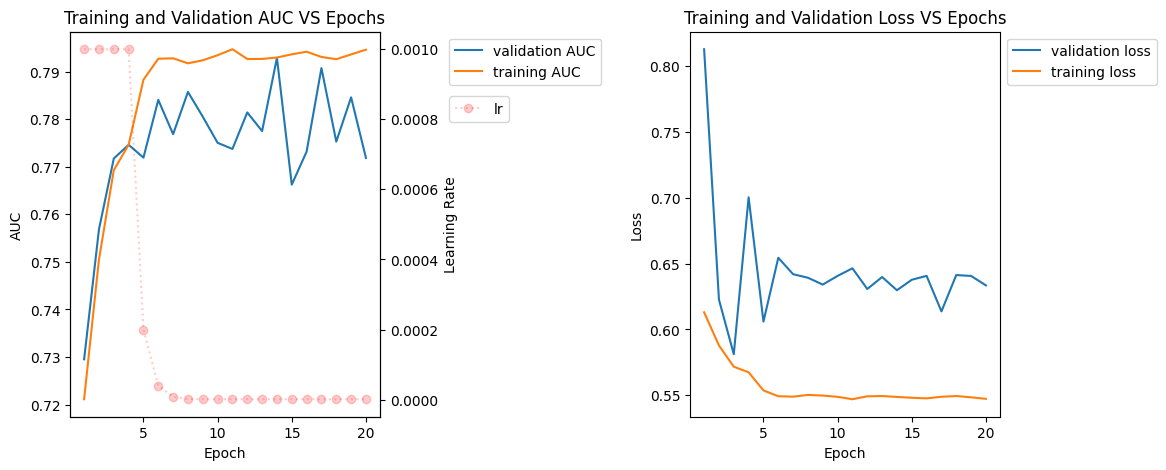

In [ ]:
# training converegence curves
model_history_plot(model_7_hist)

In [ ]:
y_pred = model.predict(
    gen_batch(testing_set, batch_size=batch_size, shuffle=False)
)
y_pred = np.reshape(y_pred, -1)

386/386 [==============================] - 2s 4ms/step


In [ ]:
len(y_pred)

12326

In [ ]:
import pandas as pd
submission = pd.DataFrame({'label':y_pred})
submission.index.name = 'id'
submission.to_csv('sample_submission_7.csv')

In [ ]:
import gc
del model
tf.keras.backend.clear_session()
gc.collect()

34375

## Model 8: Gated Graph Neural Networks - **GGNN** ⭐⭐⭐
Since model 2 that was implemented using GGNN have the highest score till now we will focus on this message passing technique for the next set of trials to see how far we can further imporve the performance using this technique by changing the hyper-parameters.

For this model we will use same settings as model 2 but will change the aggregation function to mean and add dropout. Also one single dense layer of 1 unit is used.
* Used Adam optimizer
* Used same batch size of 32 graphs/batch
* Used same GGNN message passing mechanism
* GNN number of layers 3

**Changes:**
* set "aggregation_function"] to 'mean' instead of max
* use dropout by setting "layer_input_dropout_rate" to 0.3

**AUC Scores:**
* tr_auc: 0.8551, val_auc: 0.8487
* private score: 0.83689, public score: 0.83542
* ***This is the best fitting model***, it seems that using mean pooling instead of summation is a better representation also the added dropout to the GNN input layer seems to have prevented overfitting which can also be noticed from the convergence curves.
* since this current model hyperparameters have the best obtained performance so far we will fix it and will check the effect of the dense layer for the next 2 models

Check available default hyperparameters to see which ones we can modify

In [ ]:
params = GNN.get_default_hyperparameters()
params

{'aggregation_function': 'sum',
 'message_activation_function': 'relu',
 'message_activation_before_aggregation': False,
 'hidden_dim': 16,
 'use_target_state_as_input': False,
 'normalize_by_num_incoming': True,
 'num_edge_MLP_hidden_layers': 0,
 'message_calculation_class': 'rgcn',
 'initial_node_representation_activation': 'tanh',
 'dense_intermediate_layer_activation': 'tanh',
 'num_layers': 4,
 'dense_every_num_layers': 2,
 'residual_every_num_layers': 2,
 'use_inter_layer_layernorm': False,
 'layer_input_dropout_rate': 0.0,
 'global_exchange_mode': 'gru',
 'global_exchange_every_num_layers': 2,
 'global_exchange_weighting_fun': 'softmax',
 'global_exchange_num_heads': 4,
 'global_exchange_dropout_rate': 0.2}

In [ ]:
data = keras.Input(batch_shape=(None,)) # features vector of nodes of dims -> (total_number_of_nodes_in_the_batch, number_dimensions_of_each_node which is 1 "one integer")
# where total_number_of_nodes_in_the_batch = batch_size * max_nodes_per_graph (if we do padding)

# the first dim is different to the previous one. it is the total number of edges in this batch
edge = keras.Input(batch_shape=(None, 2), dtype=tf.int32) # ajacenecy list of dims -> (number_of_edges_in_the_batch, 2)
# where 2 is because each entry in the adjacency list has 2 values (src,dst) nodes indicies


node2graph = keras.Input(batch_shape=(None,), dtype=tf.int32) # will have the same dimensions as the data -> (total_number_of_nodes_in_the_batch, 1)
# where 1 is because we have just the number of the graph to which the node belongs


embeded = Embedding(tokenizer.num_words, 20)(data) # converting the tokenized integer label of each node to a vector representation of length 20
# tokenizer.num_words --> max_vocab = 500 --> maximum number of unique nodes in all graphs --> 20*500 --> 10,000 weights to be learned
# embeded dims -> (batch_size * max_nodes_per_graph, 20) -> (total_number_of_nodes_in_the_batch, 20)

# number of graphs (number of samples) in the batch
num_graph = tf.reduce_max(node2graph)+1 # we add one because graph indicies are zero-indexed

gnn_input = GNNInput(
    node_features=embeded, # nodes features vector which is the embedded representation of the tokenized integer label of the chemical atom type
    adjacency_lists=(edge,), # passed as a tuple because we can pass different type of edges (different adjacency lists) for heterogeneous information networks
    node_to_graph_map=node2graph, # nodes graph indicies
    num_graphs=num_graph, # number of graphs in the batch
)

# https://github.com/microsoft/tf2-gnn/blob/master/tf2_gnn/layers/gnn.py
params = GNN.get_default_hyperparameters()
params["hidden_dim"] = 32 # each node will be represented as/will have a 32-vector message
params["message_calculation_class"] = 'GGNN'
params["num_layers"] = 3
params["aggregation_function"] = 'mean'
params["layer_input_dropout_rate"] = 0.3

#params["residual_every_num_layers"] = 1
#params["global_exchange_every_num_layers"] = 1
#params["dense_intermediate_layer_activation"]: 'relu'

gnn_layer = GNN(params)
gnn_out = gnn_layer(gnn_input) # output of GNN layer is of dims -> (batch_size * max_nodes_per_graph, hidden_dim) -> (total_number_of_nodes_in_the_batch, 32)

print('gnn_out', gnn_out)

# https://www.tensorflow.org/api_docs/python/tf/math/segment_mean
# Since our goal is to classify each individual graph we'll need to have a graph level representation rather than node-level ones
# So we need to aggregate the nodes of each graph, one way to do so is by using mean pooling using tf segment_mean function which will take averages of the specified segements
# avg will be of dims -> (batch_size, hidden_dim) -> (number_of_graphs_in_the_batch, 32)
avg = segment_mean(
    data=gnn_out,
    segment_ids=node2graph
)
print('mean:', avg)

# now we can use these graph-level representations in classification tasks using fully connected layers
# fc_1 = Dense(32,activation='tanh')(avg)
# fc_2 = Dense(16,activation='tanh')(fc_1)
pred = Dense(1, activation='sigmoid')(avg)
print('pred:', pred)

model = Model(
    inputs={
        'data': data,
        'edges': edge,
        'node2grah': node2graph,
    },
    outputs=pred
)
model.summary()

gnn_out KerasTensor(type_spec=TensorSpec(shape=(None, 32), dtype=tf.float32, name=None), name='gnn_1/StatefulPartitionedCall:0', description="created by layer 'gnn_1'")
mean: KerasTensor(type_spec=TensorSpec(shape=(None, 32), dtype=tf.float32, name=None), name='tf.math.segment_mean_1/SegmentMean:0', description="created by layer 'tf.math.segment_mean_1'")
pred: KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), name='dense_1/Sigmoid:0', description="created by layer 'dense_1'")
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None,)]            0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None,)]            0           []        

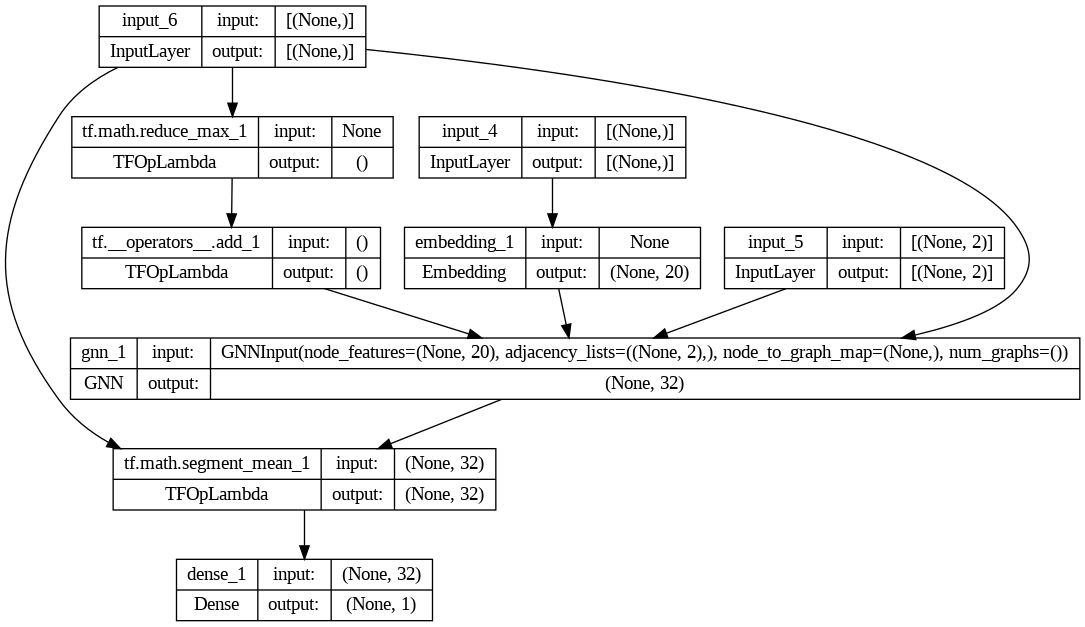

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [ ]:
model.compile(
    optimizer=Adam(learning_rate=1e-3),
    loss='BinaryCrossentropy',
    metrics=['AUC'],
)

In [ ]:
# defining early stop criteria
earlystop_callback =  keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, start_from_epoch = 8)

# defining learning rate scheduler
lr_reduction = ReduceLROnPlateau(monitor='val_loss',
                                patience=1,
                                verbose=1,
                                factor=0.2,
                                min_delta = 0.001,
                                min_lr=1e-6)

In [ ]:
%%time
import math

batch_size = 32
num_batchs = math.ceil(len(training_set) / batch_size) # number of training batches
num_batchs_validation = math.ceil(len(validation_set) / batch_size) # number of validation batches

model_8_hist = model.fit(
                gen_batch(training_set, batch_size=batch_size, repeat=True),
                steps_per_epoch=num_batchs,
                epochs=50,
                validation_data=gen_batch(
                validation_set, batch_size=batch_size, repeat=True),
                validation_steps=num_batchs_validation,
                callbacks=[earlystop_callback, lr_reduction],
)

Epoch 1/50
1265/1265 [==============================] - 35s 23ms/step - loss: 0.6325 - auc: 0.6912 - val_loss: 0.7464 - val_auc: 0.7402 - lr: 0.0010
Epoch 2/50
1265/1265 [==============================] - 21s 17ms/step - loss: 0.6015 - auc: 0.7360 - val_loss: 0.7222 - val_auc: 0.7597 - lr: 0.0010
Epoch 3/50
1265/1265 [==============================] - 21s 17ms/step - loss: 0.5817 - auc: 0.7583 - val_loss: 0.6390 - val_auc: 0.7850 - lr: 0.0010
Epoch 4/50
1265/1265 [==============================] - 19s 15ms/step - loss: 0.5584 - auc: 0.7849 - val_loss: 0.6358 - val_auc: 0.7980 - lr: 0.0010
Epoch 5/50
1265/1265 [==============================] - 18s 15ms/step - loss: 0.5314 - auc: 0.8111 - val_loss: 0.4955 - val_auc: 0.8050 - lr: 0.0010
Epoch 6/50
1265/1265 [==============================] - 19s 15ms/step - loss: 0.5160 - auc: 0.8241 - val_loss: 0.4740 - val_auc: 0.8470 - lr: 0.0010
Epoch 7/50
1265/1265 [==============================] - ETA: 0s - loss: 0.4998 - auc: 0.8369
Epoch 7: Redu

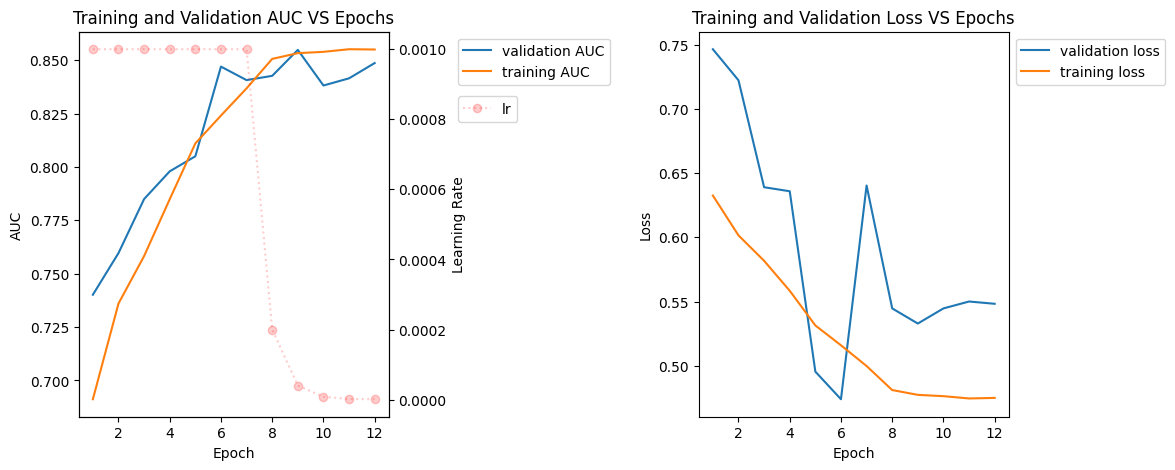

In [ ]:
# training converegence curves
model_history_plot(model_8_hist)

In [ ]:
y_pred = model.predict(
    gen_batch(testing_set, batch_size=batch_size, shuffle=False)
)
y_pred = np.reshape(y_pred, -1)

386/386 [==============================] - 3s 8ms/step


In [ ]:
len(y_pred)

12326

In [ ]:
import pandas as pd
submission = pd.DataFrame({'label':y_pred})
submission.index.name = 'id'
submission.to_csv('sample_submission_8.csv')

In [ ]:
import gc
del model
tf.keras.backend.clear_session()
gc.collect()

11325

## Model 9: Gated Graph Neural Networks - **GGNN**
Since model 8 gave the best results till now will keep its settings and check the effect of the dense layer by adding more fully connected layers before the final output layer

* Used Adam optimizer
* Used same batch size of 32 graphs/batch
* Used same GGNN message passing mechanism
* GNN number of layers 3
* set "aggregation_function"] to 'mean' instead of max
* use dropout by setting "layer_input_dropout_rate"] to 0.3

**Changes:**
* Added 2 fully connected layers before the final dense layer in model 8 with dropout layers between each fully connected layer

**AUC Scores:**
* tr_auc: 0.7714, val_auc: 0.7739
* private score: 0.75853, public score: 0.77715
* model is clearly under fitting and is having worse perfromance than model 8
* it is possible that the added dropout layers was high enough for the model to lose info and underfit the data so next we'll remove this dropout layers and check how the model will perform


Check available default hyperparameters to see which ones we can modify

In [ ]:
params = GNN.get_default_hyperparameters()
params

{'aggregation_function': 'sum',
 'message_activation_function': 'relu',
 'message_activation_before_aggregation': False,
 'hidden_dim': 16,
 'use_target_state_as_input': False,
 'normalize_by_num_incoming': True,
 'num_edge_MLP_hidden_layers': 0,
 'message_calculation_class': 'rgcn',
 'initial_node_representation_activation': 'tanh',
 'dense_intermediate_layer_activation': 'tanh',
 'num_layers': 4,
 'dense_every_num_layers': 2,
 'residual_every_num_layers': 2,
 'use_inter_layer_layernorm': False,
 'layer_input_dropout_rate': 0.0,
 'global_exchange_mode': 'gru',
 'global_exchange_every_num_layers': 2,
 'global_exchange_weighting_fun': 'softmax',
 'global_exchange_num_heads': 4,
 'global_exchange_dropout_rate': 0.2}

In [ ]:
data = keras.Input(batch_shape=(None,)) # features vector of nodes of dims -> (total_number_of_nodes_in_the_batch, number_dimensions_of_each_node which is 1 "one integer")
# where total_number_of_nodes_in_the_batch = batch_size * max_nodes_per_graph (if we do padding)

# the first dim is different to the previous one. it is the total number of edges in this batch
edge = keras.Input(batch_shape=(None, 2), dtype=tf.int32) # ajacenecy list of dims -> (number_of_edges_in_the_batch, 2)
# where 2 is because each entry in the adjacency list has 2 values (src,dst) nodes indicies


node2graph = keras.Input(batch_shape=(None,), dtype=tf.int32) # will have the same dimensions as the data -> (total_number_of_nodes_in_the_batch, 1)
# where 1 is because we have just the number of the graph to which the node belongs


embeded = Embedding(tokenizer.num_words, 20)(data) # converting the tokenized integer label of each node to a vector representation of length 20
# tokenizer.num_words --> max_vocab = 500 --> maximum number of unique nodes in all graphs --> 20*500 --> 10,000 weights to be learned
# embeded dims -> (batch_size * max_nodes_per_graph, 20) -> (total_number_of_nodes_in_the_batch, 20)

# number of graphs (number of samples) in the batch
num_graph = tf.reduce_max(node2graph)+1 # we add one because graph indicies are zero-indexed

gnn_input = GNNInput(
    node_features=embeded, # nodes features vector which is the embedded representation of the tokenized integer label of the chemical atom type
    adjacency_lists=(edge,), # passed as a tuple because we can pass different type of edges (different adjacency lists) for heterogeneous information networks
    node_to_graph_map=node2graph, # nodes graph indicies
    num_graphs=num_graph, # number of graphs in the batch
)

# https://github.com/microsoft/tf2-gnn/blob/master/tf2_gnn/layers/gnn.py
params = GNN.get_default_hyperparameters()
params["hidden_dim"] = 32 # each node will be represented as/will have a 32-vector message
params["message_calculation_class"] = 'GGNN'
params["num_layers"] = 3
params["aggregation_function"] = 'mean'
params["layer_input_dropout_rate"] = 0.3

gnn_layer = GNN(params)
gnn_out = gnn_layer(gnn_input) # output of GNN layer is of dims -> (batch_size * max_nodes_per_graph, hidden_dim) -> (total_number_of_nodes_in_the_batch, 32)

print('gnn_out', gnn_out)

# https://www.tensorflow.org/api_docs/python/tf/math/segment_mean
# Since our goal is to classify each individual graph we'll need to have a graph level representation rather than node-level ones
# So we need to aggregate the nodes of each graph, one way to do so is by using mean pooling using tf segment_mean function which will take averages of the specified segements
# avg will be of dims -> (batch_size, hidden_dim) -> (number_of_graphs_in_the_batch, 32)
avg = segment_mean(
    data=gnn_out,
    segment_ids=node2graph
)
print('mean:', avg)

# now we can use these graph-level representations in classification tasks using fully connected layers
fc_1 = Dense(128,activation='tanh')(avg)
dr_1 = Dropout(0.5)(fc_1)
fc_2 = Dense(64,activation='tanh')(dr_1)
dr_2 = Dropout(0.5)(fc_2)
pred = Dense(1, activation='sigmoid')(dr_2)

print('pred:', pred)

model = Model(
    inputs={
        'data': data,
        'edges': edge,
        'node2grah': node2graph,
    },
    outputs=pred
)
model.summary()

gnn_out KerasTensor(type_spec=TensorSpec(shape=(None, 32), dtype=tf.float32, name=None), name='gnn/StatefulPartitionedCall:0', description="created by layer 'gnn'")
mean: KerasTensor(type_spec=TensorSpec(shape=(None, 32), dtype=tf.float32, name=None), name='tf.math.segment_mean/SegmentMean:0', description="created by layer 'tf.math.segment_mean'")
pred: KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), name='dense_2/Sigmoid:0', description="created by layer 'dense_2'")
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None,)]            0           []                               
                                                                                                  
 input_1 (InputLayer)           [(None,)]            0           []                  

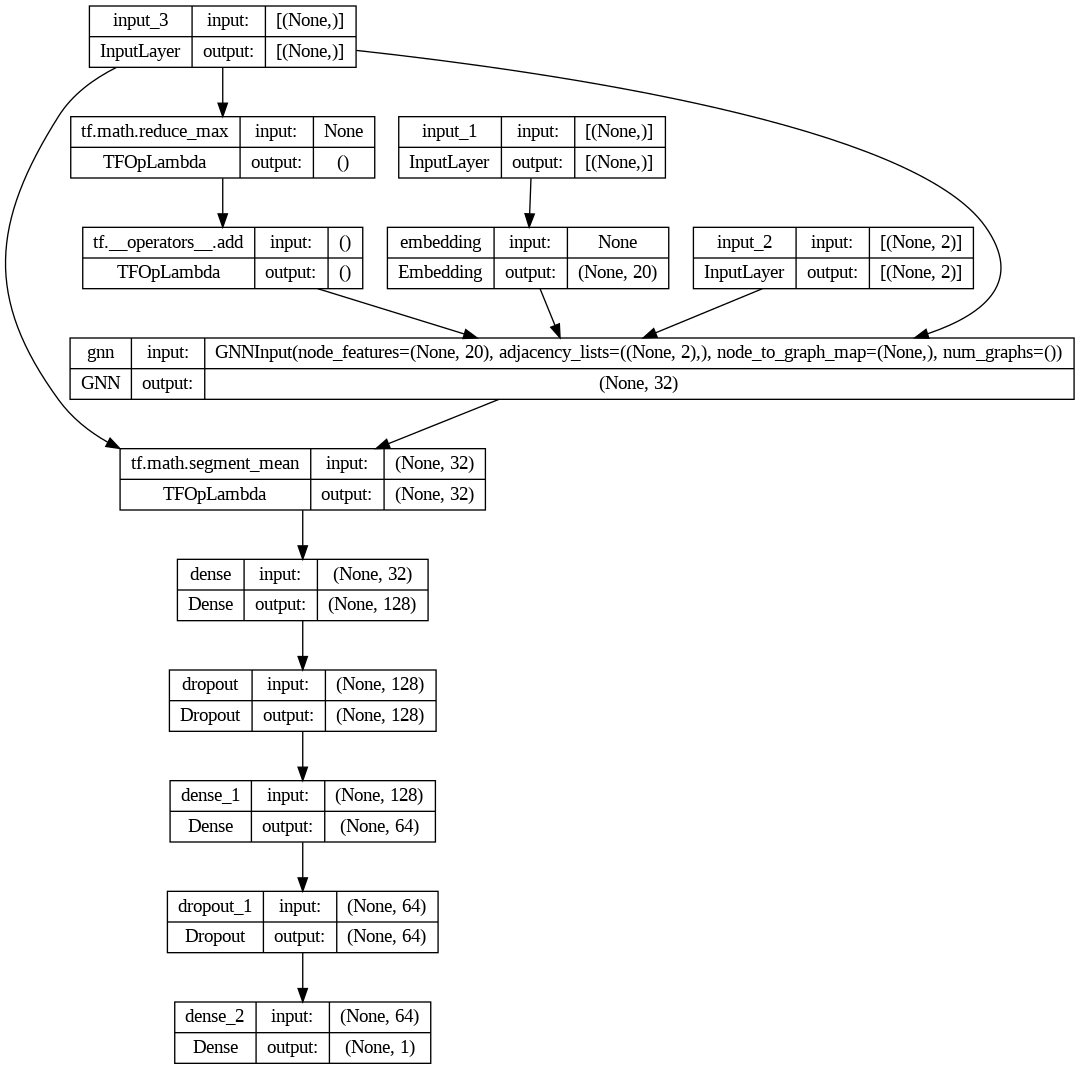

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [ ]:
model.compile(
    optimizer=Adam(learning_rate=1e-3),
    loss='BinaryCrossentropy',
    metrics=['AUC'],
)

In [ ]:
# defining early stop criteria
earlystop_callback =  keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, start_from_epoch = 8)

# defining learning rate scheduler
lr_reduction = ReduceLROnPlateau(monitor='val_loss',
                                patience=1,
                                verbose=1,
                                factor=0.2,
                                min_delta = 0.001,
                                min_lr=1e-6)

In [ ]:
%%time
import math

batch_size = 32
num_batchs = math.ceil(len(training_set) / batch_size) # number of training batches
num_batchs_validation = math.ceil(len(validation_set) / batch_size) # number of validation batches

model_9_hist = model.fit(
                gen_batch(training_set, batch_size=batch_size, repeat=True),
                steps_per_epoch=num_batchs,
                epochs=50,
                validation_data=gen_batch(
                validation_set, batch_size=batch_size, repeat=True),
                validation_steps=num_batchs_validation,
                callbacks=[earlystop_callback, lr_reduction],
)

Epoch 1/50
1265/1265 [==============================] - 37s 25ms/step - loss: 0.6379 - auc: 0.6855 - val_loss: 0.7059 - val_auc: 0.7318 - lr: 0.0010
Epoch 2/50
1265/1265 [==============================] - 20s 16ms/step - loss: 0.6095 - auc: 0.7273 - val_loss: 0.6040 - val_auc: 0.7422 - lr: 0.0010
Epoch 3/50
1265/1265 [==============================] - ETA: 0s - loss: 0.6002 - auc: 0.7382
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
1265/1265 [==============================] - 21s 17ms/step - loss: 0.6002 - auc: 0.7382 - val_loss: 0.7329 - val_auc: 0.7556 - lr: 0.0010
Epoch 4/50
1264/1265 [============================>.] - ETA: 0s - loss: 0.5812 - auc: 0.7591
Epoch 4: ReduceLROnPlateau reducing learning rate to 4.0000001899898055e-05.
1265/1265 [==============================] - 21s 17ms/step - loss: 0.5811 - auc: 0.7592 - val_loss: 0.6081 - val_auc: 0.7772 - lr: 2.0000e-04
Epoch 5/50
1265/1265 [==============================] - ETA: 0s - loss: 0.5733 - a

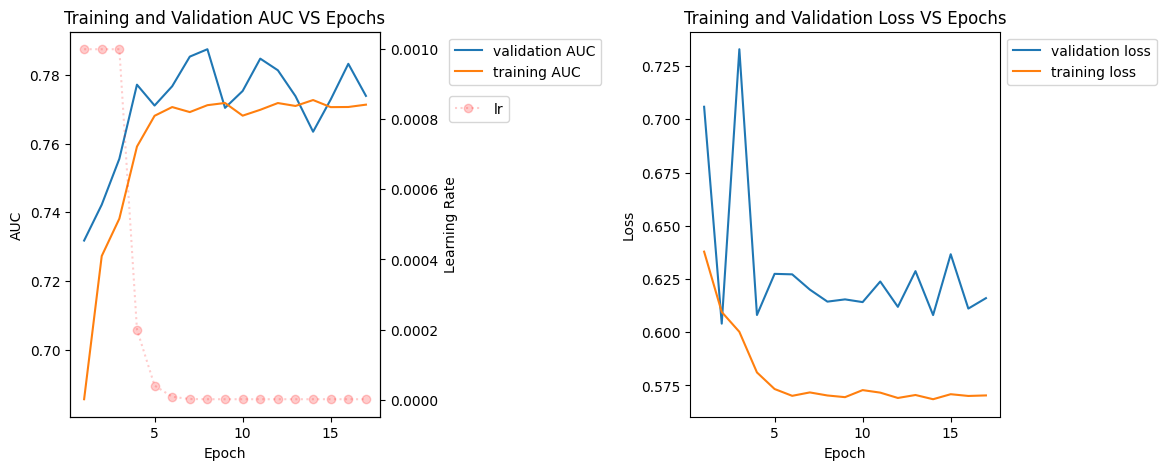

In [ ]:
# training converegence curves
model_history_plot(model_9_hist)

In [ ]:
y_pred = model.predict(
    gen_batch(testing_set, batch_size=batch_size, shuffle=False)
)
y_pred = np.reshape(y_pred, -1)

386/386 [==============================] - 3s 7ms/step


In [ ]:
len(y_pred)

12326

In [ ]:
import pandas as pd
submission = pd.DataFrame({'label':y_pred})
submission.index.name = 'id'
submission.to_csv('sample_submission_9.csv')

In [ ]:
import gc
del model
tf.keras.backend.clear_session()
gc.collect()

36261

## Model 10: Gated Graph Neural Networks - **GGNN**
Continuing with assessing the fully connected layer effect on model 8 we implemented model 9 where we added 2 additional fully connected layers with dropout layers in between. Since model 9 was underfitting due to the added dropout layers we'll make a trial by removing them and check the performance.

* Used Adam optimizer
* Used same batch size of 32 graphs/batch
* Used same GGNN message passing mechanism
* GNN number of layers 3
* set "aggregation_function"] to 'mean' instead of max
* use dropout by setting "layer_input_dropout_rate"] to 0.3

**Changes:**
* Kept the 2 fully connected layers before the final dense layer as in model 9
* Removed the dropout layers that were in between the dense layers

**AUC Scores:**
* tr_auc: 0.7903, val_auc: 0.7911
* private score: 0.77757, public score: 0.80518
* so model is better than model 9 but it is still under fitting! scores are worse than model 8 in which we used 1 dense layer with just 1 unit
* so in next model we will keep the dense layer design the same as model 8 as it gave the best results when compared by trials of models 9 and 10 and will check the effect of changing the dimensions of the vectors and batches


Check available default hyperparameters to see which ones we can modify

In [ ]:
params = GNN.get_default_hyperparameters()
params

{'aggregation_function': 'sum',
 'message_activation_function': 'relu',
 'message_activation_before_aggregation': False,
 'hidden_dim': 16,
 'use_target_state_as_input': False,
 'normalize_by_num_incoming': True,
 'num_edge_MLP_hidden_layers': 0,
 'message_calculation_class': 'rgcn',
 'initial_node_representation_activation': 'tanh',
 'dense_intermediate_layer_activation': 'tanh',
 'num_layers': 4,
 'dense_every_num_layers': 2,
 'residual_every_num_layers': 2,
 'use_inter_layer_layernorm': False,
 'layer_input_dropout_rate': 0.0,
 'global_exchange_mode': 'gru',
 'global_exchange_every_num_layers': 2,
 'global_exchange_weighting_fun': 'softmax',
 'global_exchange_num_heads': 4,
 'global_exchange_dropout_rate': 0.2}

In [ ]:
data = keras.Input(batch_shape=(None,)) # features vector of nodes of dims -> (total_number_of_nodes_in_the_batch, number_dimensions_of_each_node which is 1 "one integer")
# where total_number_of_nodes_in_the_batch = batch_size * max_nodes_per_graph (if we do padding)

# the first dim is different to the previous one. it is the total number of edges in this batch
edge = keras.Input(batch_shape=(None, 2), dtype=tf.int32) # ajacenecy list of dims -> (number_of_edges_in_the_batch, 2)
# where 2 is because each entry in the adjacency list has 2 values (src,dst) nodes indicies


node2graph = keras.Input(batch_shape=(None,), dtype=tf.int32) # will have the same dimensions as the data -> (total_number_of_nodes_in_the_batch, 1)
# where 1 is because we have just the number of the graph to which the node belongs


embeded = Embedding(tokenizer.num_words, 20)(data) # converting the tokenized integer label of each node to a vector representation of length 20
# tokenizer.num_words --> max_vocab = 500 --> maximum number of unique nodes in all graphs --> 20*500 --> 10,000 weights to be learned
# embeded dims -> (batch_size * max_nodes_per_graph, 20) -> (total_number_of_nodes_in_the_batch, 20)

# number of graphs (number of samples) in the batch
num_graph = tf.reduce_max(node2graph)+1 # we add one because graph indicies are zero-indexed

gnn_input = GNNInput(
    node_features=embeded, # nodes features vector which is the embedded representation of the tokenized integer label of the chemical atom type
    adjacency_lists=(edge,), # passed as a tuple because we can pass different type of edges (different adjacency lists) for heterogeneous information networks
    node_to_graph_map=node2graph, # nodes graph indicies
    num_graphs=num_graph, # number of graphs in the batch
)

# https://github.com/microsoft/tf2-gnn/blob/master/tf2_gnn/layers/gnn.py
params = GNN.get_default_hyperparameters()
params["hidden_dim"] = 32 # each node will be represented as/will have a 32-vector message
params["message_calculation_class"] = 'GGNN'
params["num_layers"] = 3
params["aggregation_function"] = 'mean'
params["layer_input_dropout_rate"] = 0.3

gnn_layer = GNN(params)
gnn_out = gnn_layer(gnn_input) # output of GNN layer is of dims -> (batch_size * max_nodes_per_graph, hidden_dim) -> (total_number_of_nodes_in_the_batch, 32)

print('gnn_out', gnn_out)

# https://www.tensorflow.org/api_docs/python/tf/math/segment_mean
# Since our goal is to classify each individual graph we'll need to have a graph level representation rather than node-level ones
# So we need to aggregate the nodes of each graph, one way to do so is by using mean pooling using tf segment_mean function which will take averages of the specified segements
# avg will be of dims -> (batch_size, hidden_dim) -> (number_of_graphs_in_the_batch, 32)
avg = segment_mean(
    data=gnn_out,
    segment_ids=node2graph
)
print('mean:', avg)

# now we can use these graph-level representations in classification tasks using fully connected layers
fc_1 = Dense(128,activation='tanh')(avg)
fc_2 = Dense(64,activation='tanh')(fc_1)
pred = Dense(1, activation='sigmoid')(fc_2)

print('pred:', pred)

model = Model(
    inputs={
        'data': data,
        'edges': edge,
        'node2grah': node2graph,
    },
    outputs=pred
)
model.summary()

gnn_out KerasTensor(type_spec=TensorSpec(shape=(None, 32), dtype=tf.float32, name=None), name='gnn/StatefulPartitionedCall:0', description="created by layer 'gnn'")
mean: KerasTensor(type_spec=TensorSpec(shape=(None, 32), dtype=tf.float32, name=None), name='tf.math.segment_mean/SegmentMean:0', description="created by layer 'tf.math.segment_mean'")
pred: KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), name='dense_2/Sigmoid:0', description="created by layer 'dense_2'")
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None,)]            0           []                               
                                                                                                  
 input_1 (InputLayer)           [(None,)]            0           []                  

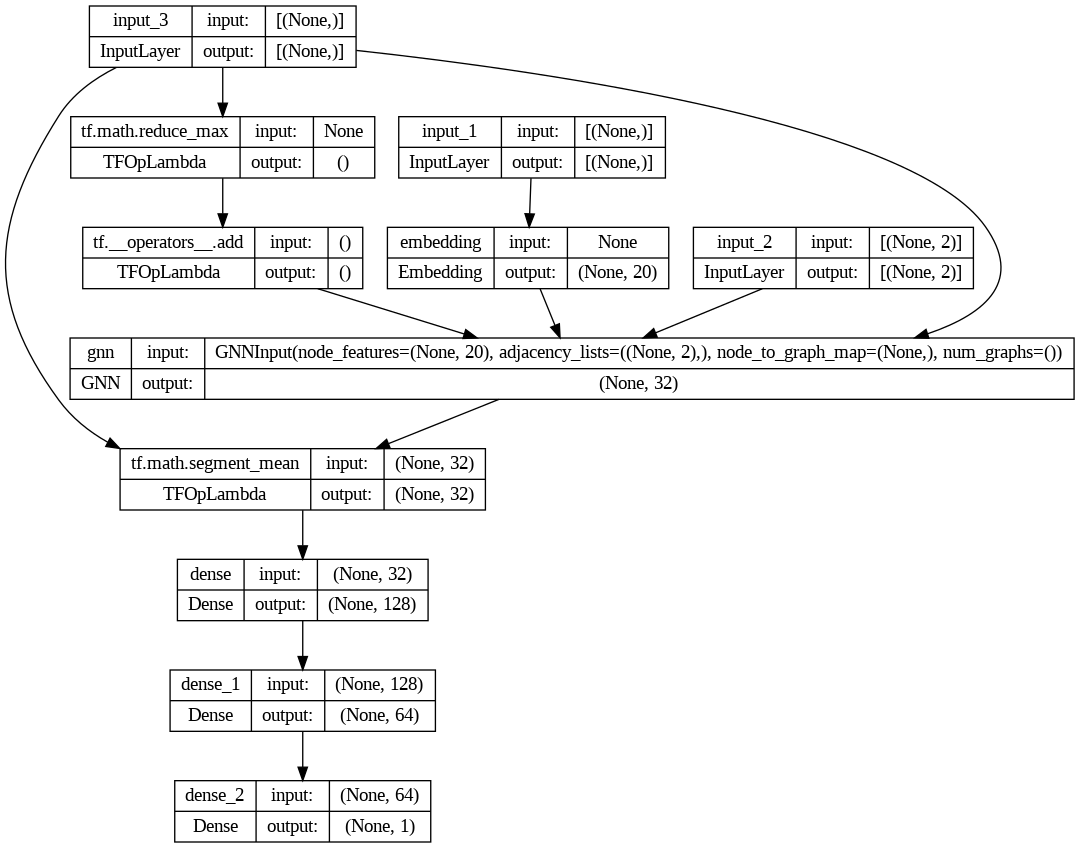

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [ ]:
model.compile(
    optimizer=Adam(learning_rate=1e-3),
    loss='BinaryCrossentropy',
    metrics=['AUC'],
)

In [ ]:
# defining early stop criteria
earlystop_callback =  keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, start_from_epoch = 8)

# defining learning rate scheduler
lr_reduction = ReduceLROnPlateau(monitor='val_loss',
                                patience=1,
                                verbose=1,
                                factor=0.2,
                                min_delta = 0.001,
                                min_lr=1e-6)

In [ ]:
%%time
import math

batch_size = 32
num_batchs = math.ceil(len(training_set) / batch_size) # number of training batches
num_batchs_validation = math.ceil(len(validation_set) / batch_size) # number of validation batches

model_10_hist = model.fit(
                gen_batch(training_set, batch_size=batch_size, repeat=True),
                steps_per_epoch=num_batchs,
                epochs=50,
                validation_data=gen_batch(
                validation_set, batch_size=batch_size, repeat=True),
                validation_steps=num_batchs_validation,
                callbacks=[earlystop_callback, lr_reduction],
)

Epoch 1/50
1265/1265 [==============================] - 29s 18ms/step - loss: 0.6299 - auc: 0.6981 - val_loss: 0.5816 - val_auc: 0.7382 - lr: 0.0010
Epoch 2/50
1265/1265 [==============================] - 20s 16ms/step - loss: 0.6009 - auc: 0.7344 - val_loss: 0.5505 - val_auc: 0.7537 - lr: 0.0010
Epoch 3/50
1265/1265 [==============================] - ETA: 0s - loss: 0.5832 - auc: 0.7543
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
1265/1265 [==============================] - 22s 17ms/step - loss: 0.5832 - auc: 0.7543 - val_loss: 0.5778 - val_auc: 0.7797 - lr: 0.0010
Epoch 4/50
1264/1265 [============================>.] - ETA: 0s - loss: 0.5601 - auc: 0.7807
Epoch 4: ReduceLROnPlateau reducing learning rate to 4.0000001899898055e-05.
1265/1265 [==============================] - 20s 16ms/step - loss: 0.5602 - auc: 0.7807 - val_loss: 0.5698 - val_auc: 0.7841 - lr: 2.0000e-04
Epoch 5/50
1264/1265 [============================>.] - ETA: 0s - loss: 0.5540 - a

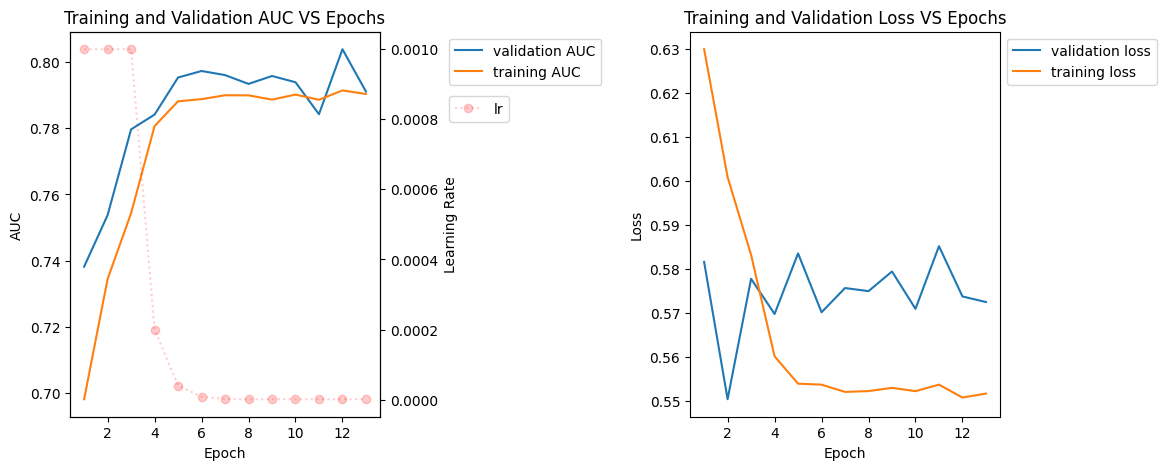

In [ ]:
# training converegence curves
model_history_plot(model_10_hist)

In [ ]:
y_pred = model.predict(
    gen_batch(testing_set, batch_size=batch_size, shuffle=False)
)
y_pred = np.reshape(y_pred, -1)

386/386 [==============================] - 3s 7ms/step


In [ ]:
len(y_pred)

12326

In [ ]:
import pandas as pd
submission = pd.DataFrame({'label':y_pred})
submission.index.name = 'id'
submission.to_csv('sample_submission_10.csv')

In [ ]:
import gc
del model
tf.keras.backend.clear_session()
gc.collect()

59977

## Model 11: Gated Graph Neural Networks - **GGNN**
Continuing with the GGNN message passing technique:

For this model we will use same dense layer settings as model 8 and GGNN hyperparameters but will see the effects of changing the batch size and the embedding vector length and nodes message vetcor length on the performance.

* Used Adam optimizer
* Used same GGNN message passing mechanism
* GNN number of layers 3
* set "aggregation_function"] to 'mean' instead of max
* use dropout by setting "layer_input_dropout_rate"] to 0.3

**Changes:**
* Use batch size of **64** graphs/batch instead of 32
* Use embedded vector of length **64** instead of 20
* Will represent each message as a **64** vector instead of 32

**AUC Scores:**
* tr_auc: 0.8392, val_auc: 0.8091
* private score: 0.81568, public score: 0.83197
* the obatined score is less than that of model 8 however its appropriatley fitting the data. From this difference in results we can deduce that increasing the vector lengths was not beneficial to the learning task, we cant say if there is a specific vector that is degrading the performance after increasing its length or all vectors are contributing to this degradation as we will need to test each vector effect separately
* so for the next trial we will use model 8 dense layer settings as well as vectors dimensions but will try another set of hyperparameters on it.

Check available default hyperparameters to see which ones we can modify

In [ ]:
params = GNN.get_default_hyperparameters()
params

{'aggregation_function': 'sum',
 'message_activation_function': 'relu',
 'message_activation_before_aggregation': False,
 'hidden_dim': 16,
 'use_target_state_as_input': False,
 'normalize_by_num_incoming': True,
 'num_edge_MLP_hidden_layers': 0,
 'message_calculation_class': 'rgcn',
 'initial_node_representation_activation': 'tanh',
 'dense_intermediate_layer_activation': 'tanh',
 'num_layers': 4,
 'dense_every_num_layers': 2,
 'residual_every_num_layers': 2,
 'use_inter_layer_layernorm': False,
 'layer_input_dropout_rate': 0.0,
 'global_exchange_mode': 'gru',
 'global_exchange_every_num_layers': 2,
 'global_exchange_weighting_fun': 'softmax',
 'global_exchange_num_heads': 4,
 'global_exchange_dropout_rate': 0.2}

In [ ]:
data = keras.Input(batch_shape=(None,)) # features vector of nodes of dims -> (total_number_of_nodes_in_the_batch, number_dimensions_of_each_node which is 1 "one integer")
# where total_number_of_nodes_in_the_batch = batch_size * max_nodes_per_graph (if we do padding)

# the first dim is different to the previous one. it is the total number of edges in this batch
edge = keras.Input(batch_shape=(None, 2), dtype=tf.int32) # ajacenecy list of dims -> (number_of_edges_in_the_batch, 2)
# where 2 is because each entry in the adjacency list has 2 values (src,dst) nodes indicies


node2graph = keras.Input(batch_shape=(None,), dtype=tf.int32) # will have the same dimensions as the data -> (total_number_of_nodes_in_the_batch, 1)
# where 1 is because we have just the number of the graph to which the node belongs


embeded = Embedding(tokenizer.num_words, 64)(data) # converting the tokenized integer label of each node to a vector representation of length 64
# tokenizer.num_words --> max_vocab = 500 --> maximum number of unique nodes in all graphs --> 64*500 --> 32,000 weights to be learned
# embeded dims -> (batch_size * max_nodes_per_graph, 64) -> (total_number_of_nodes_in_the_batch, 64)

# number of graphs (number of samples) in the batch
num_graph = tf.reduce_max(node2graph)+1 # we add one because graph indicies are zero-indexed

gnn_input = GNNInput(
    node_features=embeded, # nodes features vector which is the embedded representation of the tokenized integer label of the chemical atom type
    adjacency_lists=(edge,), # passed as a tuple because we can pass different type of edges (different adjacency lists) for heterogeneous information networks
    node_to_graph_map=node2graph, # nodes graph indicies
    num_graphs=num_graph, # number of graphs in the batch
)

# https://github.com/microsoft/tf2-gnn/blob/master/tf2_gnn/layers/gnn.py
params = GNN.get_default_hyperparameters()
params["hidden_dim"] = 64 # each node will be represented as/will have a 64-vector message
params["message_calculation_class"] = 'GGNN'
params["num_layers"] = 3
params["aggregation_function"] = 'mean'
params["layer_input_dropout_rate"] = 0.3

#params["residual_every_num_layers"] = 1
#params["global_exchange_every_num_layers"] = 1
#params["dense_intermediate_layer_activation"]: 'relu'

gnn_layer = GNN(params)
gnn_out = gnn_layer(gnn_input) # output of GNN layer is of dims -> (batch_size * max_nodes_per_graph, hidden_dim) -> (total_number_of_nodes_in_the_batch, 64)

print('gnn_out', gnn_out)

# https://www.tensorflow.org/api_docs/python/tf/math/segment_mean
# Since our goal is to classify each individual graph we'll need to have a graph level representation rather than node-level ones
# So we need to aggregate the nodes of each graph, one way to do so is by using mean pooling using tf segment_mean function which will take averages of the specified segements
# avg will be of dims -> (batch_size, hidden_dim) -> (number_of_graphs_in_the_batch, 64)
avg = segment_mean(
    data=gnn_out,
    segment_ids=node2graph
)
print('mean:', avg)

# now we can use these graph-level representations in classification tasks using fully connected layers
pred = Dense(1, activation='sigmoid')(avg)
print('pred:', pred)

model = Model(
    inputs={
        'data': data,
        'edges': edge,
        'node2grah': node2graph,
    },
    outputs=pred
)
model.summary()

gnn_out KerasTensor(type_spec=TensorSpec(shape=(None, 64), dtype=tf.float32, name=None), name='gnn/StatefulPartitionedCall:0', description="created by layer 'gnn'")
mean: KerasTensor(type_spec=TensorSpec(shape=(None, 64), dtype=tf.float32, name=None), name='tf.math.segment_mean/SegmentMean:0', description="created by layer 'tf.math.segment_mean'")
pred: KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), name='dense/Sigmoid:0', description="created by layer 'dense'")
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None,)]            0           []                               
                                                                                                  
 input_1 (InputLayer)           [(None,)]            0           []                      

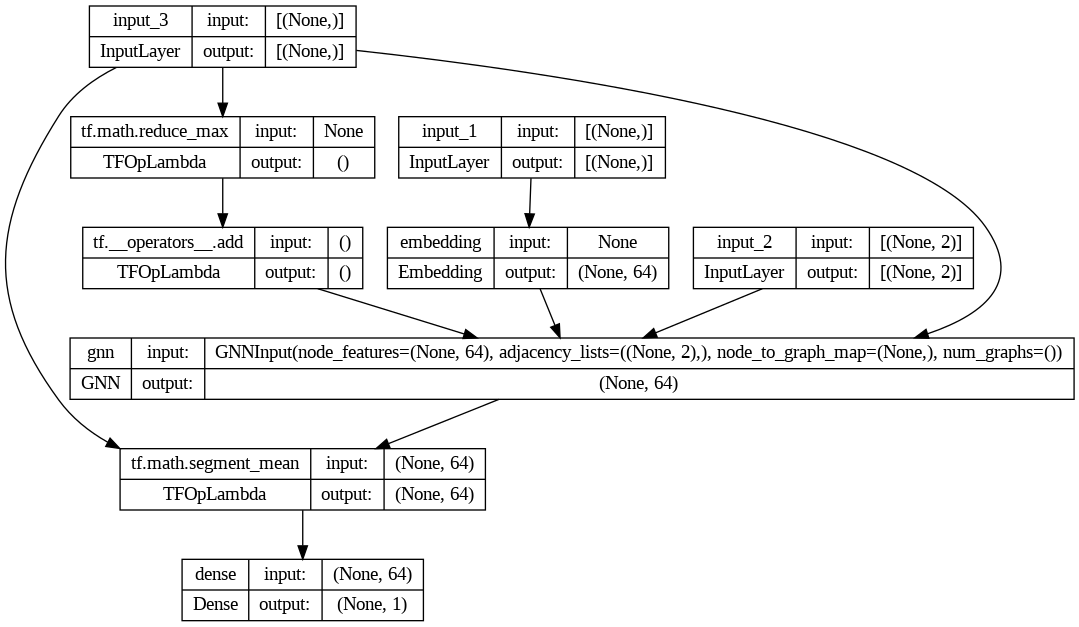

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [ ]:
model.compile(
    optimizer=Adam(learning_rate=1e-3),
    loss='BinaryCrossentropy',
    metrics=['AUC'],
)

In [ ]:
# defining early stop criteria
earlystop_callback =  keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, start_from_epoch = 8)

# defining learning rate scheduler
lr_reduction = ReduceLROnPlateau(monitor='val_loss',
                                patience=1,
                                verbose=1,
                                factor=0.2,
                                min_delta = 0.001,
                                min_lr=1e-6)

In [ ]:
%%time
import math

batch_size = 64
num_batchs = math.ceil(len(training_set) / batch_size) # number of training batches
num_batchs_validation = math.ceil(len(validation_set) / batch_size) # number of validation batches

model_11_hist = model.fit(
                gen_batch(training_set, batch_size=batch_size, repeat=True),
                steps_per_epoch=num_batchs,
                epochs=50,
                validation_data=gen_batch(
                validation_set, batch_size=batch_size, repeat=True),
                validation_steps=num_batchs_validation,
                callbacks=[earlystop_callback, lr_reduction],
)

Epoch 1/50
633/633 [==============================] - 21s 22ms/step - loss: 0.6290 - auc: 0.6974 - val_loss: 0.6604 - val_auc: 0.7400 - lr: 0.0010
Epoch 2/50
633/633 [==============================] - 12s 19ms/step - loss: 0.5875 - auc: 0.7481 - val_loss: 0.6369 - val_auc: 0.7578 - lr: 0.0010
Epoch 3/50
633/633 [==============================] - ETA: 0s - loss: 0.5541 - auc: 0.7895
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
633/633 [==============================] - 11s 18ms/step - loss: 0.5541 - auc: 0.7895 - val_loss: 0.6629 - val_auc: 0.8060 - lr: 0.0010
Epoch 4/50
633/633 [==============================] - ETA: 0s - loss: 0.5116 - auc: 0.8278
Epoch 4: ReduceLROnPlateau reducing learning rate to 4.0000001899898055e-05.
633/633 [==============================] - 12s 20ms/step - loss: 0.5116 - auc: 0.8278 - val_loss: 0.6380 - val_auc: 0.8172 - lr: 2.0000e-04
Epoch 5/50
633/633 [==============================] - 10s 16ms/step - loss: 0.5012 - auc: 0.83

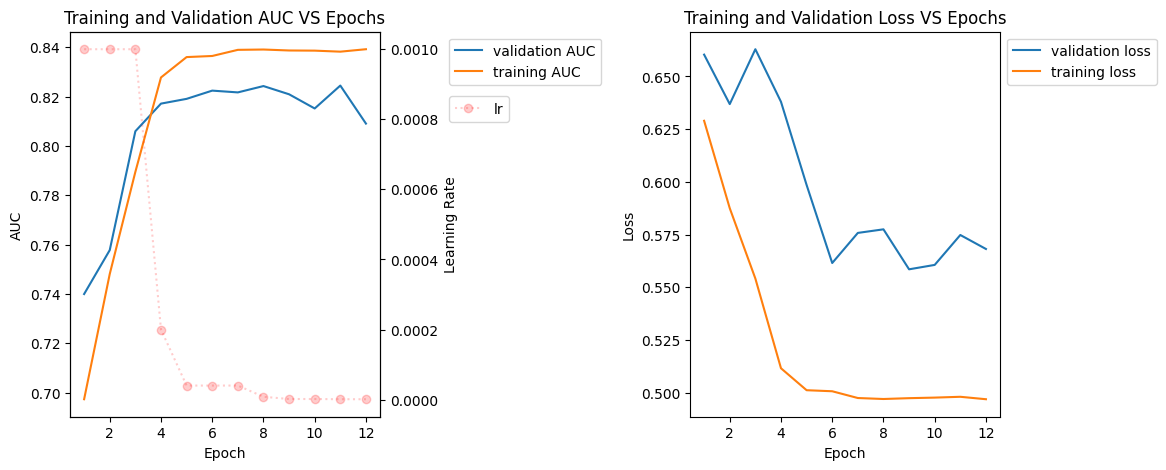

In [ ]:
# training converegence curves
model_history_plot(model_11_hist)

In [ ]:
y_pred = model.predict(
    gen_batch(testing_set, batch_size=batch_size, shuffle=False)
)
y_pred = np.reshape(y_pred, -1)

193/193 [==============================] - 2s 9ms/step


In [ ]:
len(y_pred)

12326

In [ ]:
import pandas as pd
submission = pd.DataFrame({'label':y_pred})
submission.index.name = 'id'
submission.to_csv('sample_submission_11.csv')

In [ ]:
import gc
del model
tf.keras.backend.clear_session()
gc.collect()

39179

## Model 12: Gated Graph Neural Networks - **GGNN**
Continuing with the GGNN message passing technique:

For this model we will use same dense layer settings as model 8 and vectors dimensions settings and previouly set GGNN hyperparameters as they proved to be optimal till now but will introduce another set of additional hyperparameters to try and check their effect

* Used Adam optimizer
* Used same GGNN message passing mechanism
* GNN number of layers 3
* set "aggregation_function"] to 'mean' instead of max
* use dropout by setting "layer_input_dropout_rate"] to 0.3

**Changes:**
* Add residual connection after every GNN layer
* Adjust "global_exchange_every_num_layers" which configures how often a graph-level exchange of information is performed for which, a graph level representation is computed and then used to update the representation of each node, to be performed after each GNN layer.

**AUC Scores:**
* tr_auc: 0.8123, val_auc: 0.7877
* private score: 0.80913, public score: 0.81486
* It seems that graph-level exchange of information to update the representation of each node after each GNN layer is not helping the model to learn better however it is not that bad comapred with previous models that used other message passing techniques than GGNN.

Check available default hyperparameters to see which ones we can modify

In [ ]:
params = GNN.get_default_hyperparameters()
params

{'aggregation_function': 'sum',
 'message_activation_function': 'relu',
 'message_activation_before_aggregation': False,
 'hidden_dim': 16,
 'use_target_state_as_input': False,
 'normalize_by_num_incoming': True,
 'num_edge_MLP_hidden_layers': 0,
 'message_calculation_class': 'rgcn',
 'initial_node_representation_activation': 'tanh',
 'dense_intermediate_layer_activation': 'tanh',
 'num_layers': 4,
 'dense_every_num_layers': 2,
 'residual_every_num_layers': 2,
 'use_inter_layer_layernorm': False,
 'layer_input_dropout_rate': 0.0,
 'global_exchange_mode': 'gru',
 'global_exchange_every_num_layers': 2,
 'global_exchange_weighting_fun': 'softmax',
 'global_exchange_num_heads': 4,
 'global_exchange_dropout_rate': 0.2}

In [ ]:
data = keras.Input(batch_shape=(None,)) # features vector of nodes of dims -> (total_number_of_nodes_in_the_batch, number_dimensions_of_each_node which is 1 "one integer")
# where total_number_of_nodes_in_the_batch = batch_size * max_nodes_per_graph (if we do padding)

# the first dim is different to the previous one. it is the total number of edges in this batch
edge = keras.Input(batch_shape=(None, 2), dtype=tf.int32) # ajacenecy list of dims -> (number_of_edges_in_the_batch, 2)
# where 2 is because each entry in the adjacency list has 2 values (src,dst) nodes indicies


node2graph = keras.Input(batch_shape=(None,), dtype=tf.int32) # will have the same dimensions as the data -> (total_number_of_nodes_in_the_batch, 1)
# where 1 is because we have just the number of the graph to which the node belongs


embeded = Embedding(tokenizer.num_words, 20)(data) # converting the tokenized integer label of each node to a vector representation of length 20
# tokenizer.num_words --> max_vocab = 500 --> maximum number of unique nodes in all graphs --> 20*500 --> 10,000 weights to be learned
# embeded dims -> (batch_size * max_nodes_per_graph, 20) -> (total_number_of_nodes_in_the_batch, 20)

# number of graphs (number of samples) in the batch
num_graph = tf.reduce_max(node2graph)+1 # we add one because graph indicies are zero-indexed

gnn_input = GNNInput(
    node_features=embeded, # nodes features vector which is the embedded representation of the tokenized integer label of the chemical atom type
    adjacency_lists=(edge,), # passed as a tuple because we can pass different type of edges (different adjacency lists) for heterogeneous information networks
    node_to_graph_map=node2graph, # nodes graph indicies
    num_graphs=num_graph, # number of graphs in the batch
)

# https://github.com/microsoft/tf2-gnn/blob/master/tf2_gnn/layers/gnn.py
params = GNN.get_default_hyperparameters()
params["hidden_dim"] = 32 # each node will be represented as/will have a 32-vector message
params["message_calculation_class"] = 'GGNN'
params["num_layers"] = 3
params["aggregation_function"] = 'mean'
params["layer_input_dropout_rate"] = 0.3
params["residual_every_num_layers"] = 1
params["global_exchange_every_num_layers"] = 1

gnn_layer = GNN(params)
gnn_out = gnn_layer(gnn_input) # output of GNN layer is of dims -> (batch_size * max_nodes_per_graph, hidden_dim) -> (total_number_of_nodes_in_the_batch, 32)

print('gnn_out', gnn_out)

# https://www.tensorflow.org/api_docs/python/tf/math/segment_mean
# Since our goal is to classify each individual graph we'll need to have a graph level representation rather than node-level ones
# So we need to aggregate the nodes of each graph, one way to do so is by using mean pooling using tf segment_mean function which will take averages of the specified segements
# avg will be of dims -> (batch_size, hidden_dim) -> (number_of_graphs_in_the_batch, 32)
avg = segment_mean(
    data=gnn_out,
    segment_ids=node2graph
)
print('mean:', avg)

# now we can use these graph-level representations in classification tasks using fully connected layers
pred = Dense(1, activation='sigmoid')(avg)
print('pred:', pred)

model = Model(
    inputs={
        'data': data,
        'edges': edge,
        'node2grah': node2graph,
    },
    outputs=pred
)
model.summary()

gnn_out KerasTensor(type_spec=TensorSpec(shape=(None, 32), dtype=tf.float32, name=None), name='gnn/StatefulPartitionedCall:0', description="created by layer 'gnn'")
mean: KerasTensor(type_spec=TensorSpec(shape=(None, 32), dtype=tf.float32, name=None), name='tf.math.segment_mean/SegmentMean:0', description="created by layer 'tf.math.segment_mean'")
pred: KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), name='dense/Sigmoid:0', description="created by layer 'dense'")
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None,)]            0           []                               
                                                                                                  
 input_1 (InputLayer)           [(None,)]            0           []                      

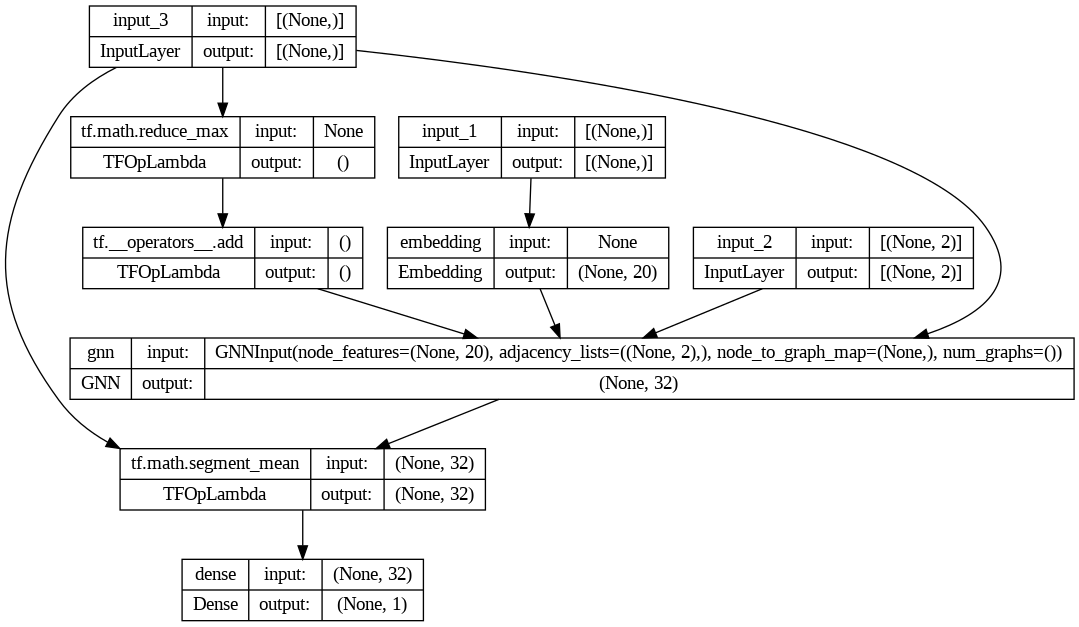

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [ ]:
model.compile(
    optimizer=Adam(learning_rate=1e-3),
    loss='BinaryCrossentropy',
    metrics=['AUC'],
)

In [ ]:
# defining early stop criteria
earlystop_callback =  keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, start_from_epoch = 8)

# defining learning rate scheduler
lr_reduction = ReduceLROnPlateau(monitor='val_loss',
                                patience=1,
                                verbose=1,
                                factor=0.2,
                                min_delta = 0.001,
                                min_lr=1e-6)

In [ ]:
%%time
import math

batch_size = 32
num_batchs = math.ceil(len(training_set) / batch_size) # number of training batches
num_batchs_validation = math.ceil(len(validation_set) / batch_size) # number of validation batches

model_12_hist = model.fit(
                gen_batch(training_set, batch_size=batch_size, repeat=True),
                steps_per_epoch=num_batchs,
                epochs=50,
                validation_data=gen_batch(
                validation_set, batch_size=batch_size, repeat=True),
                validation_steps=num_batchs_validation,
                callbacks=[earlystop_callback, lr_reduction],
)

Epoch 1/50
1265/1265 [==============================] - 38s 25ms/step - loss: 0.6318 - auc: 0.6904 - val_loss: 0.7082 - val_auc: 0.7255 - lr: 0.0010
Epoch 2/50
1265/1265 [==============================] - 24s 19ms/step - loss: 0.5989 - auc: 0.7378 - val_loss: 0.6580 - val_auc: 0.7501 - lr: 0.0010
Epoch 3/50
1265/1265 [==============================] - 26s 21ms/step - loss: 0.5803 - auc: 0.7581 - val_loss: 0.5422 - val_auc: 0.7746 - lr: 0.0010
Epoch 4/50
1265/1265 [==============================] - ETA: 0s - loss: 0.5606 - auc: 0.7812
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
1265/1265 [==============================] - 30s 24ms/step - loss: 0.5606 - auc: 0.7812 - val_loss: 0.6385 - val_auc: 0.7960 - lr: 0.0010
Epoch 5/50
1264/1265 [============================>.] - ETA: 0s - loss: 0.5365 - auc: 0.8063
Epoch 5: ReduceLROnPlateau reducing learning rate to 4.0000001899898055e-05.
1265/1265 [==============================] - 25s 19ms/step - loss: 0.5366 -

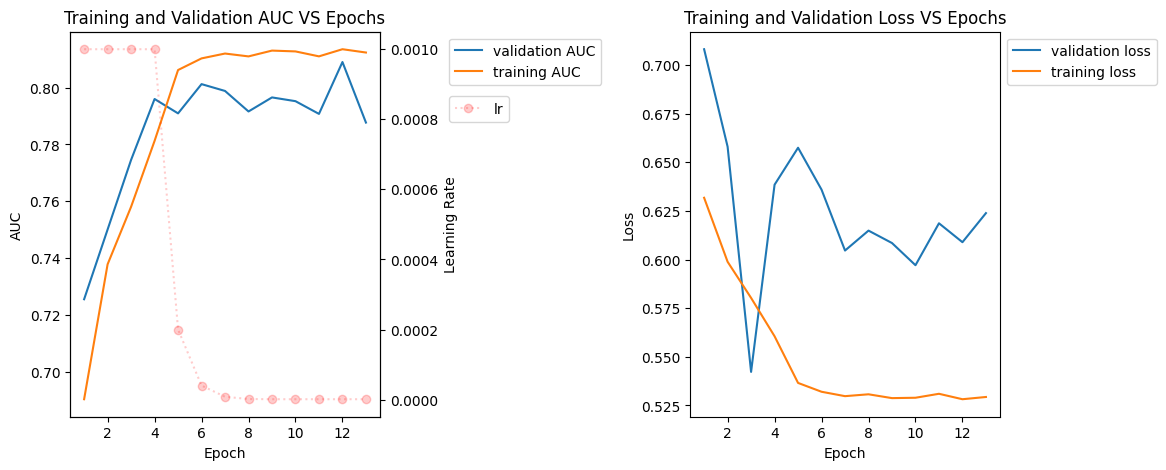

In [ ]:
# training converegence curves
model_history_plot(model_12_hist)

In [ ]:
y_pred = model.predict(
    gen_batch(testing_set, batch_size=batch_size, shuffle=False)
)
y_pred = np.reshape(y_pred, -1)

386/386 [==============================] - 3s 8ms/step


In [ ]:
len(y_pred)

12326

In [ ]:
import pandas as pd
submission = pd.DataFrame({'label':y_pred})
submission.index.name = 'id'
submission.to_csv('sample_submission_12.csv')

In [ ]:
import gc
del model
tf.keras.backend.clear_session()
gc.collect()

11875